# Modelo de Clusterização - Segmentação de Voos, Aeroportos e Companhias Aéreas

Este notebook implementa um pipeline completo de Machine Learning para **segmentação e análise de clusters** no dataset de voos comerciais dos EUA (2015).

## Objetivo
Identificar grupos naturais nos dados para auxiliar na **segmentação operacional e estratégica**, permitindo:
- Identificar perfis de aeroportos similares
- Agrupar rotas por características operacionais
- Segmentar companhias aéreas por performance

## Pipeline Implementado
1. **Carregamento e Preparação dos Dados**
2. **Feature Engineering** (Agregação de métricas)
3. **Pré-processamento** (Normalização, Tratamento de Outliers)
4. **Determinação do Número Ótimo de Clusters** (Elbow Method, Silhouette Score)
5. **Treinamento de Modelos** (K-Means, DBSCAN, Hierarchical Clustering, GMM)
6. **Avaliação e Comparação** (Silhouette Score, Davies-Bouldin Index)
7. **Análise e Interpretação dos Clusters**
8. **Visualizações** (PCA, t-SNE)
9. **Modelo Final e Conclusões**

---
**Baseado nas recomendações da Análise Exploratória de Dados (EDA)**

## 1. Importação de Bibliotecas

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Pré-processamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Modelos de Clusterização
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture

# Métricas de Avaliação
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Visualização de dendrogramas
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Seed para reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 60)
print("BIBLIOTECAS IMPORTADAS COM SUCESSO")
print("=" * 60)
print(f"\n✅ Pandas: {pd.__version__}")
print(f"✅ NumPy: {np.__version__}")
print(f"✅ Scikit-learn: Clustering Algorithms Ready")
print(f"✅ SciPy: Hierarchical Clustering Ready")
print(f"✅ Visualização: Matplotlib + Seaborn Ready")

BIBLIOTECAS IMPORTADAS COM SUCESSO

✅ Pandas: 2.3.3
✅ NumPy: 2.4.0
✅ Scikit-learn: Clustering Algorithms Ready
✅ SciPy: Hierarchical Clustering Ready
✅ Visualização: Matplotlib + Seaborn Ready


## 2. Carregamento dos Dados

In [2]:
# Carregando os datasets
print("=" * 60)
print("CARREGAMENTO DOS DADOS")
print("=" * 60)

# Companhias aéreas
airlines = pd.read_csv('../data/airlines.csv')
print(f"\n✓ Airlines: {airlines.shape[0]} registros, {airlines.shape[1]} colunas")

# Aeroportos
airports = pd.read_csv('../data/airports.csv')
print(f"✓ Airports: {airports.shape[0]} registros, {airports.shape[1]} colunas")

# Voos
flights = pd.read_csv('../data/flights.csv')
print(f"✓ Flights: {flights.shape[0]:,} registros, {flights.shape[1]} colunas")

print("\n✅ Dados carregados com sucesso!")

# Visão geral dos datasets auxiliares
print("\n" + "=" * 60)
print("COMPANHIAS AÉREAS")
print("=" * 60)
display(airlines)

print("\n" + "=" * 60)
print("AEROPORTOS (Primeiros 10)")
print("=" * 60)
display(airports.head(10))

CARREGAMENTO DOS DADOS

✓ Airlines: 14 registros, 2 colunas
✓ Airports: 322 registros, 7 colunas
✓ Flights: 5,819,079 registros, 31 colunas

✅ Dados carregados com sucesso!

COMPANHIAS AÉREAS


,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.



AEROPORTOS (Primeiros 10)


,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
5,ACK,Nantucket Memorial Airport,Nantucket,MA,USA,41.25305,-70.06018
6,ACT,Waco Regional Airport,Waco,TX,USA,31.61129,-97.23052
7,ACV,Arcata Airport,Arcata/Eureka,CA,USA,40.97812,-124.10862
8,ACY,Atlantic City International Airport,Atlantic City,NJ,USA,39.45758,-74.57717
9,ADK,Adak Airport,Adak,AK,USA,51.87796,-176.64603


## 3. Preparação dos Dados para Clusterização

### 3.1 Filtragem e Tratamento Inicial

Para os modelos de clusterização, precisamos:
- **Filtrar voos cancelados**: Usar apenas voos operados para métricas confiáveis
- **Tratar valores ausentes**: Preencher colunas de atraso com 0 (sem atraso)
- **Agregar dados**: Criar features por entidade (aeroporto, rota, companhia)

In [3]:
# Preparação inicial dos dados
print("=" * 60)
print("PREPARAÇÃO DOS DADOS")
print("=" * 60)

# Copiar o dataset
df = flights.copy()

# Estatísticas iniciais
print(f"\nTotal de voos: {len(df):,}")
print(f"Voos cancelados: {df['CANCELLED'].sum():,} ({df['CANCELLED'].sum()/len(df)*100:.2f}%)")
print(f"Voos desviados: {df['DIVERTED'].sum():,} ({df['DIVERTED'].sum()/len(df)*100:.2f}%)")

# Tratar valores ausentes em colunas de atraso
delay_columns = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 
                 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

for col in delay_columns:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        
# Tratar CANCELLATION_REASON
if 'CANCELLATION_REASON' in df.columns:
    df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Filtrar apenas voos operados para análise de performance
df_operated = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)].copy()
print(f"\nVoos operados (para métricas): {len(df_operated):,}")

# Verificar valores ausentes restantes
missing = df_operated.isnull().sum()
print(f"\nColunas com valores ausentes nos voos operados:")
print(missing[missing > 0])

PREPARAÇÃO DOS DADOS

Total de voos: 5,819,079
Voos cancelados: 89,884 (1.54%)
Voos desviados: 15,187 (0.26%)

Voos operados (para métricas): 5,714,008

Colunas com valores ausentes nos voos operados:
Series([], dtype: int64)


## 4. Feature Engineering - Agregação por Entidade

Vamos criar datasets agregados para três tipos de clusterização:

1. **Aeroportos**: Métricas agregadas por aeroporto de origem
2. **Rotas**: Métricas agregadas por par origem-destino
3. **Companhias Aéreas**: Métricas agregadas por companhia

### 4.1 Clusterização de Aeroportos

In [4]:
# Criando features agregadas por AEROPORTO DE ORIGEM
print("=" * 60)
print("FEATURE ENGINEERING - AEROPORTOS")
print("=" * 60)

# Agregar métricas por aeroporto de origem
airport_features = df.groupby('ORIGIN_AIRPORT').agg({
    # Volume
    'FLIGHT_NUMBER': 'count',
    
    # Cancelamentos e desvios (usar df completo)
    'CANCELLED': 'sum',
    'DIVERTED': 'sum',
}).reset_index()

airport_features.columns = ['AIRPORT', 'TOTAL_FLIGHTS', 'CANCELLED_COUNT', 'DIVERTED_COUNT']

# Calcular taxas
airport_features['CANCELLATION_RATE'] = (airport_features['CANCELLED_COUNT'] / 
                                          airport_features['TOTAL_FLIGHTS'] * 100)
airport_features['DIVERSION_RATE'] = (airport_features['DIVERTED_COUNT'] / 
                                       airport_features['TOTAL_FLIGHTS'] * 100)

# Agregar métricas de atraso apenas dos voos operados
delay_metrics = df_operated.groupby('ORIGIN_AIRPORT').agg({
    'DEPARTURE_DELAY': ['mean', 'std', 'median'],
    'ARRIVAL_DELAY': ['mean', 'std'],
    'TAXI_OUT': 'mean',
    'AIR_TIME': 'mean',
    'DISTANCE': 'mean',
    'AIR_SYSTEM_DELAY': 'sum',
    'AIRLINE_DELAY': 'sum',
    'WEATHER_DELAY': 'sum',
    'LATE_AIRCRAFT_DELAY': 'sum',
}).reset_index()

# Flatten column names
delay_metrics.columns = ['AIRPORT', 'AVG_DEP_DELAY', 'STD_DEP_DELAY', 'MEDIAN_DEP_DELAY',
                         'AVG_ARR_DELAY', 'STD_ARR_DELAY', 'AVG_TAXI_OUT', 'AVG_AIR_TIME',
                         'AVG_DISTANCE', 'TOTAL_AIR_SYSTEM_DELAY', 'TOTAL_AIRLINE_DELAY',
                         'TOTAL_WEATHER_DELAY', 'TOTAL_LATE_AIRCRAFT_DELAY']

# Merge features
airport_features = airport_features.merge(delay_metrics, on='AIRPORT', how='left')

# Número de companhias operando no aeroporto
airlines_per_airport = df.groupby('ORIGIN_AIRPORT')['AIRLINE'].nunique().reset_index()
airlines_per_airport.columns = ['AIRPORT', 'NUM_AIRLINES']
airport_features = airport_features.merge(airlines_per_airport, on='AIRPORT', how='left')

# Número de destinos
destinations_per_airport = df.groupby('ORIGIN_AIRPORT')['DESTINATION_AIRPORT'].nunique().reset_index()
destinations_per_airport.columns = ['AIRPORT', 'NUM_DESTINATIONS']
airport_features = airport_features.merge(destinations_per_airport, on='AIRPORT', how='left')

# Calcular percentual de atrasos por tipo
total_delay = (airport_features['TOTAL_AIR_SYSTEM_DELAY'] + airport_features['TOTAL_AIRLINE_DELAY'] + 
               airport_features['TOTAL_WEATHER_DELAY'] + airport_features['TOTAL_LATE_AIRCRAFT_DELAY'])
total_delay = total_delay.replace(0, 1)  # Evitar divisão por zero

airport_features['PCT_WEATHER_DELAY'] = airport_features['TOTAL_WEATHER_DELAY'] / total_delay * 100
airport_features['PCT_AIRLINE_DELAY'] = airport_features['TOTAL_AIRLINE_DELAY'] / total_delay * 100

# Adicionar informações do dataset de aeroportos
airport_features = airport_features.merge(
    airports[['IATA_CODE', 'AIRPORT', 'STATE', 'LATITUDE', 'LONGITUDE']], 
    left_on='AIRPORT', right_on='IATA_CODE', how='left', suffixes=('', '_NAME')
)

# Preencher valores ausentes com 0
airport_features = airport_features.fillna(0)

print(f"\n✅ Dataset de aeroportos criado: {airport_features.shape}")
print(f"\nFeatures criadas:")
for i, col in enumerate(airport_features.columns, 1):
    print(f"  {i:2}. {col}")

print(f"\nPrimeiras linhas:")
display(airport_features.head(10))

FEATURE ENGINEERING - AEROPORTOS

✅ Dataset de aeroportos criado: (930, 27)

Features criadas:
   1. AIRPORT
   2. TOTAL_FLIGHTS
   3. CANCELLED_COUNT
   4. DIVERTED_COUNT
   5. CANCELLATION_RATE
   6. DIVERSION_RATE
   7. AVG_DEP_DELAY
   8. STD_DEP_DELAY
   9. MEDIAN_DEP_DELAY
  10. AVG_ARR_DELAY
  11. STD_ARR_DELAY
  12. AVG_TAXI_OUT
  13. AVG_AIR_TIME
  14. AVG_DISTANCE
  15. TOTAL_AIR_SYSTEM_DELAY
  16. TOTAL_AIRLINE_DELAY
  17. TOTAL_WEATHER_DELAY
  18. TOTAL_LATE_AIRCRAFT_DELAY
  19. NUM_AIRLINES
  20. NUM_DESTINATIONS
  21. PCT_WEATHER_DELAY
  22. PCT_AIRLINE_DELAY
  23. IATA_CODE
  24. AIRPORT_NAME
  25. STATE
  26. LATITUDE
  27. LONGITUDE

Primeiras linhas:


,AIRPORT,TOTAL_FLIGHTS,CANCELLED_COUNT,DIVERTED_COUNT,CANCELLATION_RATE,DIVERSION_RATE,AVG_DEP_DELAY,STD_DEP_DELAY,MEDIAN_DEP_DELAY,AVG_ARR_DELAY,STD_ARR_DELAY,AVG_TAXI_OUT,AVG_AIR_TIME,AVG_DISTANCE,TOTAL_AIR_SYSTEM_DELAY,TOTAL_AIRLINE_DELAY,TOTAL_WEATHER_DELAY,TOTAL_LATE_AIRCRAFT_DELAY,NUM_AIRLINES,NUM_DESTINATIONS,PCT_WEATHER_DELAY,PCT_AIRLINE_DELAY,IATA_CODE,AIRPORT_NAME,STATE,LATITUDE,LONGITUDE
0,10135,226,0,0,0.000000,0.000000,10.075221,44.740323,-2.0,7.601770,44.993538,12.460177,98.141593,596.331858,306.0,1400.0,0.0,1103.0,2,3,0.000000,49.839801,0,0,0,0.0,0.0
1,10136,189,7,1,3.703704,0.529101,2.270718,33.456915,-6.0,-6.513812,36.291812,9.171271,34.414365,158.000000,151.0,732.0,255.0,244.0,1,1,18.451520,52.966715,0,0,0,0.0,0.0
2,10140,1712,6,4,0.350467,0.233645,5.603995,26.128083,-1.0,0.320799,27.756000,11.618684,98.257344,731.237368,1825.0,3093.0,409.0,5453.0,9,21,3.794063,28.692022,0,0,0,0.0,0.0
3,10141,67,1,0,1.492537,0.000000,1.803030,15.184222,0.0,0.606061,18.433981,15.272727,44.424242,257.000000,67.0,19.0,0.0,184.0,1,1,0.000000,7.037037,0,0,0,0.0,0.0
4,10146,82,0,1,0.000000,1.219512,9.740741,48.676426,-3.0,11.987654,50.156877,14.024691,34.469136,145.000000,116.0,740.0,0.0,253.0,1,1,0.000000,66.726781,0,0,0,0.0,0.0
5,10154,28,0,0,0.000000,0.000000,22.857143,51.747760,0.0,25.535714,58.262803,16.321429,39.357143,172.000000,251.0,471.0,0.0,108.0,1,2,0.000000,56.746988,0,0,0,0.0,0.0
6,10155,140,5,0,3.571429,0.000000,-4.133333,15.649996,-6.0,-12.725926,17.965734,8.829630,26.562963,89.000000,53.0,17.0,0.0,233.0,1,1,0.000000,5.610561,0,0,0,0.0,0.0
7,10157,113,3,0,2.654867,0.000000,12.427273,45.720222,-4.0,9.500000,46.964509,14.027273,47.054545,250.000000,502.0,10.0,0.0,1260.0,1,1,0.000000,0.564334,0,0,0,0.0,0.0
8,10158,232,1,2,0.431034,0.862069,0.052402,21.650875,-5.0,-4.882096,22.437419,10.432314,115.860262,835.965066,813.0,20.0,0.0,0.0,1,6,0.000000,2.400960,0,0,0,0.0,0.0
9,10165,9,0,0,0.000000,0.000000,17.555556,25.204717,12.0,19.555556,29.623095,11.666667,150.333333,1192.000000,31.0,62.0,0.0,0.0,1,1,0.000000,66.666667,0,0,0,0.0,0.0


### 4.2 Clusterização de Rotas

In [6]:
# Criando features agregadas por ROTA (Origem-Destino)
print("=" * 60)
print("FEATURE ENGINEERING - ROTAS")
print("=" * 60)

# Criar identificador de rota
df['ROUTE'] = df['ORIGIN_AIRPORT'].astype(str) + '-' + df['DESTINATION_AIRPORT'].astype(str)
df_operated['ROUTE'] = df_operated['ORIGIN_AIRPORT'].astype(str) + '-' + df_operated['DESTINATION_AIRPORT'].astype(str)

# Agregar métricas por rota
route_features = df.groupby('ROUTE').agg({
    'FLIGHT_NUMBER': 'count',
    'CANCELLED': 'sum',
    'DIVERTED': 'sum',
    'DISTANCE': 'first',  # Distância é fixa por rota
}).reset_index()

route_features.columns = ['ROUTE', 'TOTAL_FLIGHTS', 'CANCELLED_COUNT', 'DIVERTED_COUNT', 'DISTANCE']

# Calcular taxas
route_features['CANCELLATION_RATE'] = route_features['CANCELLED_COUNT'] / route_features['TOTAL_FLIGHTS'] * 100
route_features['DIVERSION_RATE'] = route_features['DIVERTED_COUNT'] / route_features['TOTAL_FLIGHTS'] * 100

# Agregar métricas de atraso dos voos operados
route_delay = df_operated.groupby('ROUTE').agg({
    'DEPARTURE_DELAY': ['mean', 'std', 'median'],
    'ARRIVAL_DELAY': ['mean', 'std', 'median'],
    'AIR_TIME': ['mean', 'std'],
    'TAXI_OUT': 'mean',
    'TAXI_IN': 'mean',
    'ELAPSED_TIME': 'mean',
}).reset_index()

# Flatten columns
route_delay.columns = ['ROUTE', 'AVG_DEP_DELAY', 'STD_DEP_DELAY', 'MEDIAN_DEP_DELAY',
                       'AVG_ARR_DELAY', 'STD_ARR_DELAY', 'MEDIAN_ARR_DELAY',
                       'AVG_AIR_TIME', 'STD_AIR_TIME', 'AVG_TAXI_OUT', 'AVG_TAXI_IN', 'AVG_ELAPSED_TIME']

route_features = route_features.merge(route_delay, on='ROUTE', how='left')

# Número de companhias operando a rota
airlines_per_route = df.groupby('ROUTE')['AIRLINE'].nunique().reset_index()
airlines_per_route.columns = ['ROUTE', 'NUM_AIRLINES']
route_features = route_features.merge(airlines_per_route, on='ROUTE', how='left')

# Calcular frequência média diária (considerando 365 dias)
route_features['DAILY_FREQUENCY'] = route_features['TOTAL_FLIGHTS'] / 365

# Variabilidade de atraso (coeficiente de variação)
route_features['DELAY_VARIABILITY'] = route_features['STD_ARR_DELAY'] / (route_features['AVG_ARR_DELAY'].abs() + 1)

# Preencher NaN
route_features = route_features.fillna(0)

# Filtrar rotas com mínimo de voos para análise significativa
min_flights = 100
route_features_filtered = route_features[route_features['TOTAL_FLIGHTS'] >= min_flights].copy()

print(f"\n✅ Dataset de rotas criado: {route_features.shape}")
print(f"   Rotas com >= {min_flights} voos: {len(route_features_filtered)}")
print(f"\nFeatures criadas:")
for i, col in enumerate(route_features.columns, 1):
    print(f"  {i:2}. {col}")

print(f"\nTop 10 rotas mais frequentes:")
display(route_features_filtered.nlargest(10, 'TOTAL_FLIGHTS')[['ROUTE', 'TOTAL_FLIGHTS', 'DISTANCE', 
                                                                 'AVG_ARR_DELAY', 'CANCELLATION_RATE']])

FEATURE ENGINEERING - ROTAS

✅ Dataset de rotas criado: (8609, 21)
   Rotas com >= 100 voos: 5641

Features criadas:
   1. ROUTE
   2. TOTAL_FLIGHTS
   3. CANCELLED_COUNT
   4. DIVERTED_COUNT
   5. DISTANCE
   6. CANCELLATION_RATE
   7. DIVERSION_RATE
   8. AVG_DEP_DELAY
   9. STD_DEP_DELAY
  10. MEDIAN_DEP_DELAY
  11. AVG_ARR_DELAY
  12. STD_ARR_DELAY
  13. MEDIAN_ARR_DELAY
  14. AVG_AIR_TIME
  15. STD_AIR_TIME
  16. AVG_TAXI_OUT
  17. AVG_TAXI_IN
  18. AVG_ELAPSED_TIME
  19. NUM_AIRLINES
  20. DAILY_FREQUENCY
  21. DELAY_VARIABILITY

Top 10 rotas mais frequentes:


,ROUTE,TOTAL_FLIGHTS,DISTANCE,AVG_ARR_DELAY,CANCELLATION_RATE
8099,SFO-LAX,13744,337,11.440000,2.459255
6397,LAX-SFO,13457,337,10.739187,2.541428
6181,JFK-LAX,12016,2475,-2.671560,1.173435
6362,LAX-JFK,12015,2475,0.613872,1.190179
6285,LAS-LAX,9715,236,11.974614,0.648482
6485,LGA-ORD,9639,733,3.765552,4.512916
6364,LAX-LAS,9594,236,8.655535,0.687930
7317,ORD-LGA,9575,733,10.287331,4.261097
8096,SFO-JFK,8440,2586,2.141464,1.374408
6206,JFK-SFO,8437,2586,-0.554993,1.351191


### 4.3 Clusterização de Companhias Aéreas

In [8]:
# Criando features agregadas por COMPANHIA AÉREA
print("=" * 60)
print("FEATURE ENGINEERING - COMPANHIAS AÉREAS")
print("=" * 60)

# Agregar métricas por companhia
airline_features = df.groupby('AIRLINE').agg({
    'FLIGHT_NUMBER': 'count',
    'CANCELLED': 'sum',
    'DIVERTED': 'sum',
}).reset_index()

airline_features.columns = ['AIRLINE', 'TOTAL_FLIGHTS', 'CANCELLED_COUNT', 'DIVERTED_COUNT']

# Calcular taxas
airline_features['CANCELLATION_RATE'] = airline_features['CANCELLED_COUNT'] / airline_features['TOTAL_FLIGHTS'] * 100
airline_features['DIVERSION_RATE'] = airline_features['DIVERTED_COUNT'] / airline_features['TOTAL_FLIGHTS'] * 100

# Métricas de atraso (voos operados)
airline_delay = df_operated.groupby('AIRLINE').agg({
    'DEPARTURE_DELAY': ['mean', 'std', 'median'],
    'ARRIVAL_DELAY': ['mean', 'std', 'median'],
    'AIR_TIME': 'mean',
    'DISTANCE': 'mean',
    'TAXI_OUT': 'mean',
    'TAXI_IN': 'mean',
    'AIR_SYSTEM_DELAY': 'sum',
    'AIRLINE_DELAY': 'sum',
    'WEATHER_DELAY': 'sum',
    'LATE_AIRCRAFT_DELAY': 'sum',
    'SECURITY_DELAY': 'sum',
}).reset_index()

# Flatten columns
airline_delay.columns = ['AIRLINE', 'AVG_DEP_DELAY', 'STD_DEP_DELAY', 'MEDIAN_DEP_DELAY',
                         'AVG_ARR_DELAY', 'STD_ARR_DELAY', 'MEDIAN_ARR_DELAY',
                         'AVG_AIR_TIME', 'AVG_DISTANCE', 'AVG_TAXI_OUT', 'AVG_TAXI_IN',
                         'TOTAL_AIR_SYSTEM_DELAY', 'TOTAL_AIRLINE_DELAY', 
                         'TOTAL_WEATHER_DELAY', 'TOTAL_LATE_AIRCRAFT_DELAY', 'TOTAL_SECURITY_DELAY']

airline_features = airline_features.merge(airline_delay, on='AIRLINE', how='left')

# Número de aeroportos atendidos
airports_per_airline = df.groupby('AIRLINE')['ORIGIN_AIRPORT'].nunique().reset_index()
airports_per_airline.columns = ['AIRLINE', 'NUM_AIRPORTS_SERVED']
airline_features = airline_features.merge(airports_per_airline, on='AIRLINE', how='left')

# Número de rotas operadas
routes_per_airline = df.groupby('AIRLINE')['ROUTE'].nunique().reset_index()
routes_per_airline.columns = ['AIRLINE', 'NUM_ROUTES']
airline_features = airline_features.merge(routes_per_airline, on='AIRLINE', how='left')

# Calcular métricas derivadas
# Percentual de atrasos por tipo
total_delay = (airline_features['TOTAL_AIR_SYSTEM_DELAY'] + airline_features['TOTAL_AIRLINE_DELAY'] + 
               airline_features['TOTAL_WEATHER_DELAY'] + airline_features['TOTAL_LATE_AIRCRAFT_DELAY'] +
               airline_features['TOTAL_SECURITY_DELAY'])
total_delay = total_delay.replace(0, 1)

airline_features['PCT_AIRLINE_DELAY'] = airline_features['TOTAL_AIRLINE_DELAY'] / total_delay * 100
airline_features['PCT_WEATHER_DELAY'] = airline_features['TOTAL_WEATHER_DELAY'] / total_delay * 100
airline_features['PCT_LATE_AIRCRAFT_DELAY'] = airline_features['TOTAL_LATE_AIRCRAFT_DELAY'] / total_delay * 100

# Market share
airline_features['MARKET_SHARE'] = airline_features['TOTAL_FLIGHTS'] / airline_features['TOTAL_FLIGHTS'].sum() * 100

# Variabilidade operacional
airline_features['DELAY_VARIABILITY'] = airline_features['STD_ARR_DELAY'] / (airline_features['AVG_ARR_DELAY'].abs() + 1)

# Adicionar nome da companhia
airline_features = airline_features.merge(airlines, left_on='AIRLINE', right_on='IATA_CODE', how='left')

# Preencher NaN
airline_features = airline_features.fillna(0)

print(f"\n✅ Dataset de companhias aéreas criado: {airline_features.shape}")
print(f"\nFeatures criadas:")
for i, col in enumerate(airline_features.columns, 1):
    print(f"  {i:2}. {col}")

print(f"\nResumo das companhias aéreas:")
display(airline_features[['AIRLINE_x', 'AIRLINE_y', 'TOTAL_FLIGHTS', 'MARKET_SHARE', 
                          'AVG_ARR_DELAY', 'CANCELLATION_RATE', 'NUM_AIRPORTS_SERVED']].sort_values('TOTAL_FLIGHTS', ascending=False))

FEATURE ENGINEERING - COMPANHIAS AÉREAS

✅ Dataset de companhias aéreas criado: (14, 30)

Features criadas:
   1. AIRLINE_x
   2. TOTAL_FLIGHTS
   3. CANCELLED_COUNT
   4. DIVERTED_COUNT
   5. CANCELLATION_RATE
   6. DIVERSION_RATE
   7. AVG_DEP_DELAY
   8. STD_DEP_DELAY
   9. MEDIAN_DEP_DELAY
  10. AVG_ARR_DELAY
  11. STD_ARR_DELAY
  12. MEDIAN_ARR_DELAY
  13. AVG_AIR_TIME
  14. AVG_DISTANCE
  15. AVG_TAXI_OUT
  16. AVG_TAXI_IN
  17. TOTAL_AIR_SYSTEM_DELAY
  18. TOTAL_AIRLINE_DELAY
  19. TOTAL_WEATHER_DELAY
  20. TOTAL_LATE_AIRCRAFT_DELAY
  21. TOTAL_SECURITY_DELAY
  22. NUM_AIRPORTS_SERVED
  23. NUM_ROUTES
  24. PCT_AIRLINE_DELAY
  25. PCT_WEATHER_DELAY
  26. PCT_LATE_AIRCRAFT_DELAY
  27. MARKET_SHARE
  28. DELAY_VARIABILITY
  29. IATA_CODE
  30. AIRLINE_y

Resumo das companhias aéreas:


,AIRLINE_x,AIRLINE_y,TOTAL_FLIGHTS,MARKET_SHARE,AVG_ARR_DELAY,CANCELLATION_RATE,NUM_AIRPORTS_SERVED
13,WN,Southwest Airlines Co.,1261855,21.684789,4.374964,1.271382,258
3,DL,Delta Air Lines Inc.,875881,15.051884,0.186754,0.436589,440
0,AA,American Airlines Inc.,725984,12.475926,3.451372,1.504028,276
9,OO,Skywest Airlines Inc.,588353,10.110758,5.845652,1.692861,546
4,EV,Atlantic Southeast Airlines,571977,9.829339,6.585379,2.662869,491
10,UA,United Air Lines Inc.,515723,8.862622,5.431594,1.274521,261
7,MQ,American Eagle Airlines Inc.,294632,5.063207,6.457873,5.099582,351
2,B6,JetBlue Airways,267048,4.589180,6.677861,1.601210,184
11,US,US Airways Inc.,198715,3.414887,3.706209,2.046650,79
1,AS,Alaska Airlines Inc.,172521,2.964748,-0.976563,0.387779,190


## 5. Pipeline de Clusterização

### 5.1 Funções Auxiliares para Clusterização

Vamos criar funções reutilizáveis para:
- Pré-processamento (normalização)
- Determinação do número ótimo de clusters
- Treinamento e avaliação de diferentes algoritmos
- Visualização de resultados

In [9]:
# =============================================================================
# FUNÇÕES AUXILIARES PARA CLUSTERIZAÇÃO
# =============================================================================

def preprocess_for_clustering(df, feature_columns, scaler_type='standard'):
    """
    Pré-processa os dados para clusterização.
    
    Args:
        df: DataFrame com os dados
        feature_columns: Lista de colunas numéricas para usar
        scaler_type: Tipo de scaler ('standard', 'minmax', 'robust')
    
    Returns:
        X_scaled: Dados normalizados
        scaler: Objeto scaler treinado
        feature_columns: Colunas usadas
    """
    X = df[feature_columns].copy()
    
    # Tratar infinitos e NaN
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)
    
    # Selecionar scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = RobustScaler()
    
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, scaler, feature_columns


def find_optimal_clusters_elbow(X_scaled, max_clusters=15, random_state=42):
    """
    Encontra o número ótimo de clusters usando o Método do Cotovelo (Elbow Method).
    
    Args:
        X_scaled: Dados normalizados
        max_clusters: Número máximo de clusters a testar
    
    Returns:
        inertias: Lista de inércias
        silhouettes: Lista de silhouette scores
    """
    inertias = []
    silhouettes = []
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))
    
    return list(K_range), inertias, silhouettes


def plot_elbow_silhouette(k_range, inertias, silhouettes, title=""):
    """
    Plota o gráfico do cotovelo e silhouette score.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Elbow Method
    ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Número de Clusters (k)', fontsize=12)
    ax1.set_ylabel('Inércia (Soma das Distâncias²)', fontsize=12)
    ax1.set_title(f'Método do Cotovelo - {title}', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)
    
    # Silhouette Score
    ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Número de Clusters (k)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title(f'Silhouette Score - {title}', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # Marcar o melhor silhouette
    best_k = k_range[np.argmax(silhouettes)]
    best_score = max(silhouettes)
    ax2.axvline(x=best_k, color='red', linestyle='--', label=f'Melhor k={best_k} (Score={best_score:.3f})')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return best_k


def train_clustering_models(X_scaled, n_clusters, random_state=42):
    """
    Treina múltiplos modelos de clusterização.
    
    Returns:
        Dict com modelos treinados e labels
    """
    models = {}
    
    # 1. K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    models['KMeans'] = {'model': kmeans, 'labels': kmeans_labels}
    
    # 2. Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=n_clusters, random_state=random_state, covariance_type='full')
    gmm_labels = gmm.fit_predict(X_scaled)
    models['GMM'] = {'model': gmm, 'labels': gmm_labels}
    
    # 3. Agglomerative Clustering (Hierarchical)
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_labels = agg.fit_predict(X_scaled)
    models['Hierarchical'] = {'model': agg, 'labels': agg_labels}
    
    # 4. DBSCAN (número de clusters determinado automaticamente)
    # Usar eps baseado na escala dos dados
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(n_neighbors=5)
    nn.fit(X_scaled)
    distances, _ = nn.kneighbors(X_scaled)
    eps_estimate = np.percentile(distances[:, -1], 90)
    
    dbscan = DBSCAN(eps=eps_estimate, min_samples=3)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    models['DBSCAN'] = {'model': dbscan, 'labels': dbscan_labels, 'eps': eps_estimate}
    
    return models


def evaluate_clustering(X_scaled, models):
    """
    Avalia os modelos de clusterização usando múltiplas métricas.
    
    Returns:
        DataFrame com resultados da avaliação
    """
    results = []
    
    for name, model_dict in models.items():
        labels = model_dict['labels']
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # -1 são outliers em DBSCAN
        n_noise = list(labels).count(-1) if -1 in labels else 0
        
        if n_clusters >= 2 and len(set(labels)) > 1:
            # Remover outliers para cálculo de métricas
            mask = labels != -1
            if mask.sum() > n_clusters:
                try:
                    silhouette = silhouette_score(X_scaled[mask], labels[mask])
                    davies_bouldin = davies_bouldin_score(X_scaled[mask], labels[mask])
                    calinski = calinski_harabasz_score(X_scaled[mask], labels[mask])
                except:
                    silhouette = 0
                    davies_bouldin = np.inf
                    calinski = 0
            else:
                silhouette = 0
                davies_bouldin = np.inf
                calinski = 0
        else:
            silhouette = 0
            davies_bouldin = np.inf
            calinski = 0
        
        results.append({
            'Modelo': name,
            'N_Clusters': n_clusters,
            'N_Outliers': n_noise,
            'Silhouette_Score': silhouette,
            'Davies_Bouldin': davies_bouldin,
            'Calinski_Harabasz': calinski
        })
    
    return pd.DataFrame(results)


def plot_clusters_pca(X_scaled, labels, title="", feature_names=None):
    """
    Visualiza clusters usando PCA para redução de dimensionalidade.
    """
    # Redução para 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    unique_labels = sorted(set(labels))
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        label_name = f'Outliers' if label == -1 else f'Cluster {label}'
        marker = 'x' if label == -1 else 'o'
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[color], label=label_name, 
                   marker=marker, s=100, alpha=0.7)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    ax.set_title(f'Visualização dos Clusters (PCA) - {title}', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return pca


def analyze_clusters(df, labels, feature_columns, id_column, top_n=5):
    """
    Analisa as características de cada cluster.
    
    Returns:
        DataFrame com estatísticas por cluster
    """
    df_analysis = df.copy()
    df_analysis['Cluster'] = labels
    
    # Estatísticas por cluster
    cluster_stats = df_analysis.groupby('Cluster')[feature_columns].mean()
    
    # Contagem por cluster
    cluster_counts = df_analysis['Cluster'].value_counts().sort_index()
    
    print(f"\n{'='*60}")
    print("ANÁLISE DOS CLUSTERS")
    print(f"{'='*60}")
    
    for cluster_id in sorted(df_analysis['Cluster'].unique()):
        if cluster_id == -1:
            print(f"\n🔴 Outliers (não clusterizados): {cluster_counts.get(-1, 0)} itens")
        else:
            cluster_data = df_analysis[df_analysis['Cluster'] == cluster_id]
            print(f"\n🟢 CLUSTER {cluster_id}: {len(cluster_data)} itens")
            print(f"   Exemplos: {', '.join(cluster_data[id_column].head(top_n).astype(str).tolist())}")
            print(f"   Características médias:")
            for col in feature_columns[:5]:  # Top 5 features
                print(f"      - {col}: {cluster_data[col].mean():.2f}")
    
    return cluster_stats, cluster_counts


print("✅ Funções auxiliares definidas com sucesso!")

✅ Funções auxiliares definidas com sucesso!


### 5.2 Clusterização de Aeroportos

Vamos segmentar os aeroportos por perfil operacional considerando:
- Volume de voos
- Taxa de cancelamento
- Atrasos médios
- Número de companhias e destinos
- Tipos de atraso predominantes

In [10]:
# =============================================================================
# CLUSTERIZAÇÃO DE AEROPORTOS
# =============================================================================

print("=" * 60)
print("CLUSTERIZAÇÃO DE AEROPORTOS")
print("=" * 60)

# Selecionar features para clusterização
airport_cluster_features = [
    'TOTAL_FLIGHTS',
    'CANCELLATION_RATE',
    'DIVERSION_RATE',
    'AVG_DEP_DELAY',
    'STD_DEP_DELAY',
    'AVG_ARR_DELAY',
    'AVG_TAXI_OUT',
    'AVG_DISTANCE',
    'NUM_AIRLINES',
    'NUM_DESTINATIONS',
    'PCT_WEATHER_DELAY',
    'PCT_AIRLINE_DELAY'
]

# Verificar features disponíveis
available_features = [f for f in airport_cluster_features if f in airport_features.columns]
print(f"\nFeatures selecionadas para clusterização: {len(available_features)}")
for f in available_features:
    print(f"  - {f}")

# Pré-processamento
X_airports, scaler_airports, _ = preprocess_for_clustering(
    airport_features, 
    available_features, 
    scaler_type='robust'  # Robust para lidar com outliers
)

print(f"\n✅ Dados pré-processados: {X_airports.shape}")

CLUSTERIZAÇÃO DE AEROPORTOS

Features selecionadas para clusterização: 12
  - TOTAL_FLIGHTS
  - CANCELLATION_RATE
  - DIVERSION_RATE
  - AVG_DEP_DELAY
  - STD_DEP_DELAY
  - AVG_ARR_DELAY
  - AVG_TAXI_OUT
  - AVG_DISTANCE
  - NUM_AIRLINES
  - NUM_DESTINATIONS
  - PCT_WEATHER_DELAY
  - PCT_AIRLINE_DELAY

✅ Dados pré-processados: (930, 12)



DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS - AEROPORTOS


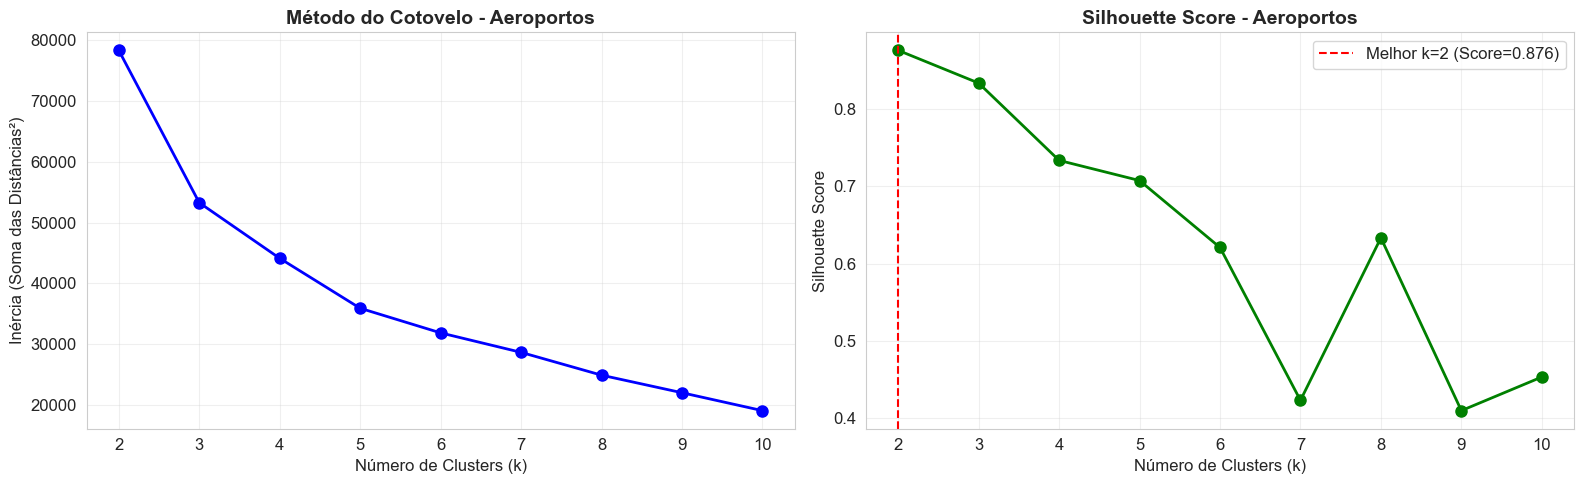


📊 Número ótimo de clusters sugerido: 2
   (baseado no melhor Silhouette Score)


In [11]:
# Encontrar número ótimo de clusters - Aeroportos
print("\n" + "=" * 60)
print("DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS - AEROPORTOS")
print("=" * 60)

k_range, inertias, silhouettes = find_optimal_clusters_elbow(X_airports, max_clusters=10)

optimal_k_airports = plot_elbow_silhouette(k_range, inertias, silhouettes, title="Aeroportos")

print(f"\n📊 Número ótimo de clusters sugerido: {optimal_k_airports}")
print(f"   (baseado no melhor Silhouette Score)")

In [12]:
# Treinar modelos de clusterização - Aeroportos
print("\n" + "=" * 60)
print("TREINAMENTO DOS MODELOS - AEROPORTOS")
print("=" * 60)

# Usar k ótimo ou valor padrão razoável
n_clusters_airports = optimal_k_airports if optimal_k_airports >= 3 else 4

print(f"\nUsando {n_clusters_airports} clusters para treinamento")

# Treinar modelos
airport_models = train_clustering_models(X_airports, n_clusters_airports)

# Avaliar modelos
airport_evaluation = evaluate_clustering(X_airports, airport_models)

print("\n📊 AVALIAÇÃO DOS MODELOS DE CLUSTERIZAÇÃO - AEROPORTOS:")
display(airport_evaluation.sort_values('Silhouette_Score', ascending=False))

# Identificar melhor modelo
best_airport_model = airport_evaluation.loc[airport_evaluation['Silhouette_Score'].idxmax(), 'Modelo']
print(f"\n🏆 Melhor modelo para Aeroportos: {best_airport_model}")


TREINAMENTO DOS MODELOS - AEROPORTOS

Usando 4 clusters para treinamento

📊 AVALIAÇÃO DOS MODELOS DE CLUSTERIZAÇÃO - AEROPORTOS:


,Modelo,N_Clusters,N_Outliers,Silhouette_Score,Davies_Bouldin,Calinski_Harabasz
0,KMeans,4,0,0.733767,0.603555,1004.378086
2,Hierarchical,4,0,0.732489,0.570078,953.882134
3,DBSCAN,7,43,0.634771,0.434267,226.640495
1,GMM,4,0,-0.018940,1.630856,223.649715



🏆 Melhor modelo para Aeroportos: KMeans



VISUALIZAÇÃO DOS CLUSTERS - AEROPORTOS


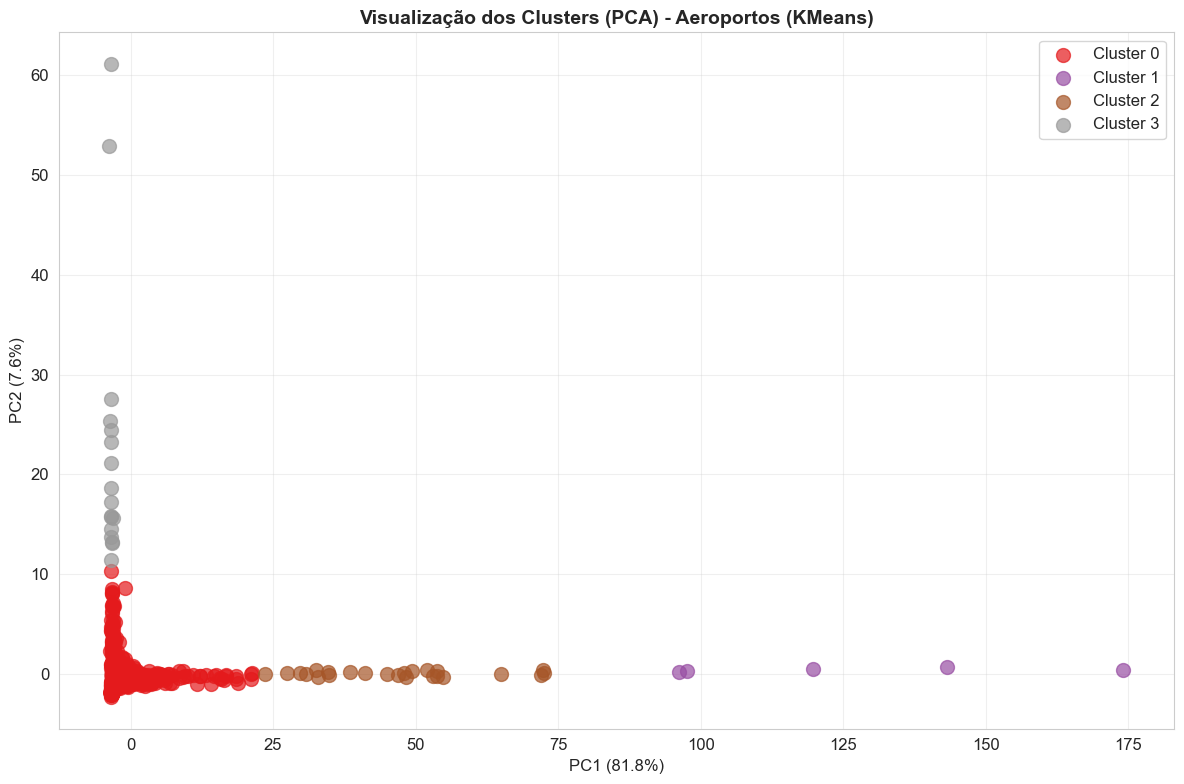

In [13]:
# Visualização dos clusters - Aeroportos (usando K-Means como modelo principal)
print("\n" + "=" * 60)
print("VISUALIZAÇÃO DOS CLUSTERS - AEROPORTOS")
print("=" * 60)

# Usar labels do melhor modelo
airport_labels = airport_models[best_airport_model]['labels']

# Visualização PCA
pca_airports = plot_clusters_pca(X_airports, airport_labels, title=f"Aeroportos ({best_airport_model})")

# Adicionar labels ao dataframe
airport_features['Cluster'] = airport_labels


ANÁLISE DETALHADA DOS CLUSTERS DE AEROPORTOS

Estatísticas médias por cluster:


,TOTAL_FLIGHTS,CANCELLATION_RATE,AVG_ARR_DELAY,NUM_AIRLINES,NUM_DESTINATIONS
Cluster,,,,,
0,2536.64,1.75,1.50,3.50,11.17
1,252599.80,1.71,6.30,11.60,139.60
2,96387.17,1.54,4.96,10.12,72.46
3,23.35,2.52,17.80,2.65,4.12


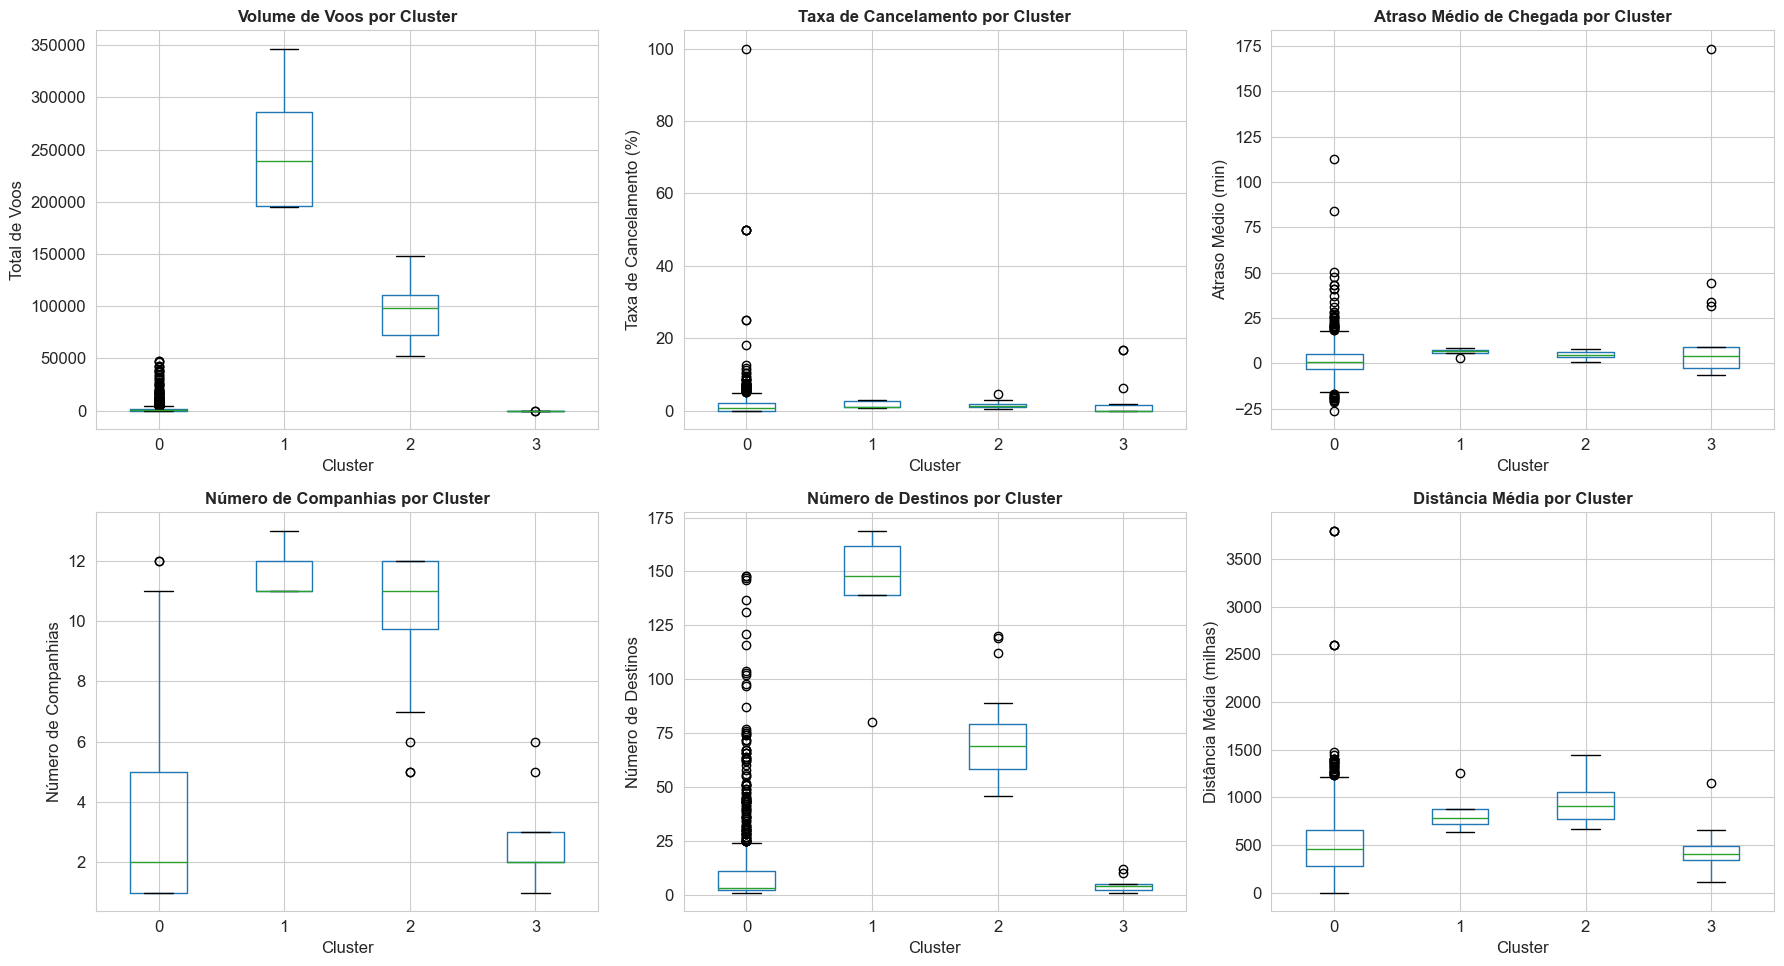


AEROPORTOS POR CLUSTER

🔵 CLUSTER 0 (884 aeroportos):
   Características médias:
   - Volume: 2,537 voos
   - Atraso médio: 1.50 min
   - Taxa cancelamento: 1.75%
   - Companhias: 3.5
   Top 5 aeroportos: BNA, PDX, STL, HNL, OAK

🔵 CLUSTER 1 (5 aeroportos):
   Características médias:
   - Volume: 252,600 voos
   - Atraso médio: 6.30 min
   - Taxa cancelamento: 1.71%
   - Companhias: 11.6
   Top 5 aeroportos: ATL, ORD, DFW, DEN, LAX

🔵 CLUSTER 2 (24 aeroportos):
   Características médias:
   - Volume: 96,387 voos
   - Atraso médio: 4.96 min
   - Taxa cancelamento: 1.54%
   - Companhias: 10.1
   Top 5 aeroportos: SFO, PHX, IAH, LAS, MSP

🔵 CLUSTER 3 (17 aeroportos):
   Características médias:
   - Volume: 23 voos
   - Atraso médio: 17.80 min
   - Taxa cancelamento: 2.52%
   - Companhias: 2.6
   Top 5 aeroportos: 11540, 13970, 15412, 14108, 15624


In [15]:
# Análise detalhada dos clusters de aeroportos
print("\n" + "=" * 60)
print("ANÁLISE DETALHADA DOS CLUSTERS DE AEROPORTOS")
print("=" * 60)

# Estatísticas por cluster
cluster_airport_stats = airport_features.groupby('Cluster')[available_features].agg(['mean', 'std', 'count'])
print("\nEstatísticas médias por cluster:")

# Resumo simplificado
summary_cols = ['TOTAL_FLIGHTS', 'CANCELLATION_RATE', 'AVG_ARR_DELAY', 'NUM_AIRLINES', 'NUM_DESTINATIONS']
cluster_summary = airport_features.groupby('Cluster')[summary_cols].mean().round(2)
display(cluster_summary)

# Visualização das características por cluster
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Volume de voos
ax1 = axes[0, 0]
airport_features.boxplot(column='TOTAL_FLIGHTS', by='Cluster', ax=ax1)
ax1.set_title('Volume de Voos por Cluster', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Total de Voos')
plt.suptitle('')

# 2. Taxa de cancelamento
ax2 = axes[0, 1]
airport_features.boxplot(column='CANCELLATION_RATE', by='Cluster', ax=ax2)
ax2.set_title('Taxa de Cancelamento por Cluster', fontsize=12, fontweight='bold')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Taxa de Cancelamento (%)')
plt.suptitle('')

# 3. Atraso médio
ax3 = axes[0, 2]
airport_features.boxplot(column='AVG_ARR_DELAY', by='Cluster', ax=ax3)
ax3.set_title('Atraso Médio de Chegada por Cluster', fontsize=12, fontweight='bold')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Atraso Médio (min)')
plt.suptitle('')

# 4. Número de companhias
ax4 = axes[1, 0]
airport_features.boxplot(column='NUM_AIRLINES', by='Cluster', ax=ax4)
ax4.set_title('Número de Companhias por Cluster', fontsize=12, fontweight='bold')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Número de Companhias')
plt.suptitle('')

# 5. Número de destinos
ax5 = axes[1, 1]
airport_features.boxplot(column='NUM_DESTINATIONS', by='Cluster', ax=ax5)
ax5.set_title('Número de Destinos por Cluster', fontsize=12, fontweight='bold')
ax5.set_xlabel('Cluster')
ax5.set_ylabel('Número de Destinos')
plt.suptitle('')

# 6. Distância média
ax6 = axes[1, 2]
airport_features.boxplot(column='AVG_DISTANCE', by='Cluster', ax=ax6)
ax6.set_title('Distância Média por Cluster', fontsize=12, fontweight='bold')
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Distância Média (milhas)')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Lista de aeroportos por cluster
print("\n" + "=" * 60)
print("AEROPORTOS POR CLUSTER")
print("=" * 60)

for cluster_id in sorted(airport_features['Cluster'].unique()):
    if cluster_id != -1:
        cluster_airports = airport_features[airport_features['Cluster'] == cluster_id]
        print(f"\n🔵 CLUSTER {cluster_id} ({len(cluster_airports)} aeroportos):")
        print(f"   Características médias:")
        print(f"   - Volume: {cluster_airports['TOTAL_FLIGHTS'].mean():,.0f} voos")
        print(f"   - Atraso médio: {cluster_airports['AVG_ARR_DELAY'].mean():.2f} min")
        print(f"   - Taxa cancelamento: {cluster_airports['CANCELLATION_RATE'].mean():.2f}%")
        print(f"   - Companhias: {cluster_airports['NUM_AIRLINES'].mean():.1f}")
        
        # Top 5 aeroportos do cluster por volume
        top_in_cluster = cluster_airports.nlargest(5, 'TOTAL_FLIGHTS')[['AIRPORT', 'TOTAL_FLIGHTS', 'AVG_ARR_DELAY']]
        print(f"   Top 5 aeroportos: {', '.join(top_in_cluster['AIRPORT'].astype(str).tolist())}")

### 5.3 Clusterização de Rotas

Vamos segmentar as rotas por características operacionais:
- Distância e tempo de voo
- Frequência de operação
- Performance de atrasos
- Taxa de cancelamento
- Variabilidade operacional

In [16]:
# =============================================================================
# CLUSTERIZAÇÃO DE ROTAS
# =============================================================================

print("=" * 60)
print("CLUSTERIZAÇÃO DE ROTAS")
print("=" * 60)

# Usar dataset filtrado (rotas com mínimo de voos)
print(f"\nUsando {len(route_features_filtered)} rotas (mínimo {min_flights} voos)")

# Selecionar features para clusterização
route_cluster_features = [
    'TOTAL_FLIGHTS',
    'DISTANCE',
    'CANCELLATION_RATE',
    'DIVERSION_RATE',
    'AVG_DEP_DELAY',
    'STD_DEP_DELAY',
    'AVG_ARR_DELAY',
    'STD_ARR_DELAY',
    'AVG_AIR_TIME',
    'AVG_TAXI_OUT',
    'AVG_TAXI_IN',
    'NUM_AIRLINES',
    'DAILY_FREQUENCY',
    'DELAY_VARIABILITY'
]

# Verificar features disponíveis
available_route_features = [f for f in route_cluster_features if f in route_features_filtered.columns]
print(f"\nFeatures selecionadas: {len(available_route_features)}")

# Pré-processamento
X_routes, scaler_routes, _ = preprocess_for_clustering(
    route_features_filtered, 
    available_route_features, 
    scaler_type='robust'
)

print(f"✅ Dados pré-processados: {X_routes.shape}")

CLUSTERIZAÇÃO DE ROTAS

Usando 5641 rotas (mínimo 100 voos)

Features selecionadas: 14
✅ Dados pré-processados: (5641, 14)



DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS - ROTAS


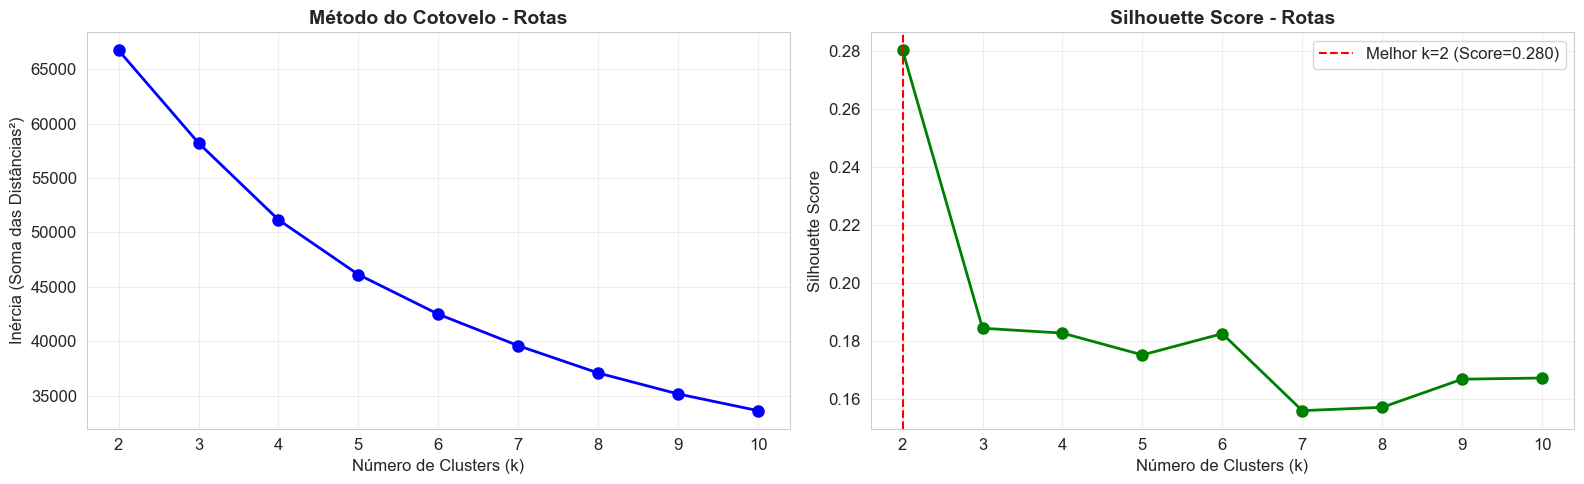


📊 Número ótimo de clusters sugerido: 2


In [17]:
# Encontrar número ótimo de clusters - Rotas
print("\n" + "=" * 60)
print("DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS - ROTAS")
print("=" * 60)

k_range_routes, inertias_routes, silhouettes_routes = find_optimal_clusters_elbow(X_routes, max_clusters=10)

optimal_k_routes = plot_elbow_silhouette(k_range_routes, inertias_routes, silhouettes_routes, title="Rotas")

print(f"\n📊 Número ótimo de clusters sugerido: {optimal_k_routes}")

In [18]:
# Treinar modelos - Rotas
print("\n" + "=" * 60)
print("TREINAMENTO DOS MODELOS - ROTAS")
print("=" * 60)

n_clusters_routes = optimal_k_routes if optimal_k_routes >= 3 else 5

print(f"\nUsando {n_clusters_routes} clusters")

# Treinar modelos
route_models = train_clustering_models(X_routes, n_clusters_routes)

# Avaliar modelos
route_evaluation = evaluate_clustering(X_routes, route_models)

print("\n📊 AVALIAÇÃO DOS MODELOS - ROTAS:")
display(route_evaluation.sort_values('Silhouette_Score', ascending=False))

# Melhor modelo
best_route_model = route_evaluation.loc[route_evaluation['Silhouette_Score'].idxmax(), 'Modelo']
print(f"\n🏆 Melhor modelo para Rotas: {best_route_model}")


TREINAMENTO DOS MODELOS - ROTAS

Usando 5 clusters

📊 AVALIAÇÃO DOS MODELOS - ROTAS:


,Modelo,N_Clusters,N_Outliers,Silhouette_Score,Davies_Bouldin,Calinski_Harabasz
0,KMeans,5,0,0.175068,1.449678,1008.944248
3,DBSCAN,7,259,0.158510,0.700916,16.772303
2,Hierarchical,5,0,0.086816,1.814519,781.647835
1,GMM,5,0,0.058458,2.450416,438.582774



🏆 Melhor modelo para Rotas: KMeans



VISUALIZAÇÃO E ANÁLISE DOS CLUSTERS - ROTAS


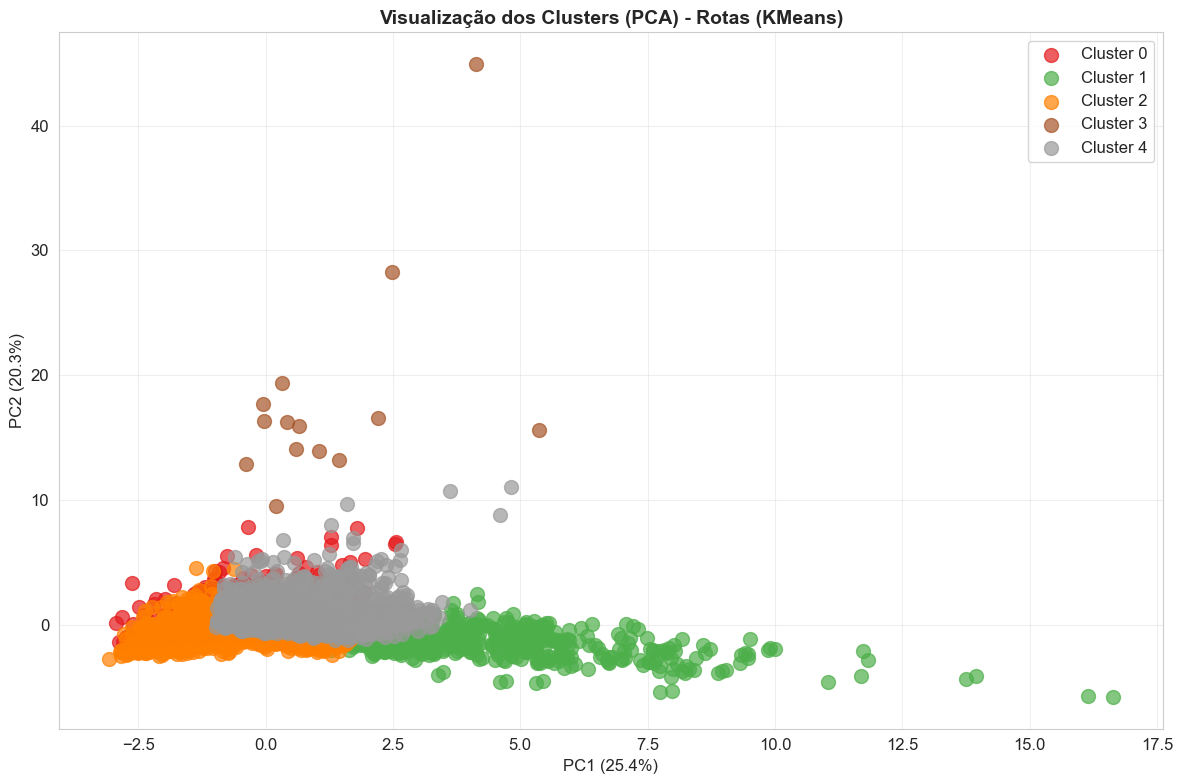


Estatísticas médias por cluster:


,TOTAL_FLIGHTS,DISTANCE,AVG_ARR_DELAY,CANCELLATION_RATE,DAILY_FREQUENCY
Cluster,,,,,
0,655.51,1743.71,0.30,0.68,1.80
1,4147.24,799.25,5.02,1.42,11.36
2,549.73,601.99,0.19,0.72,1.51
3,329.43,1183.43,12.13,2.85,0.90
4,874.54,667.11,8.87,2.80,2.40


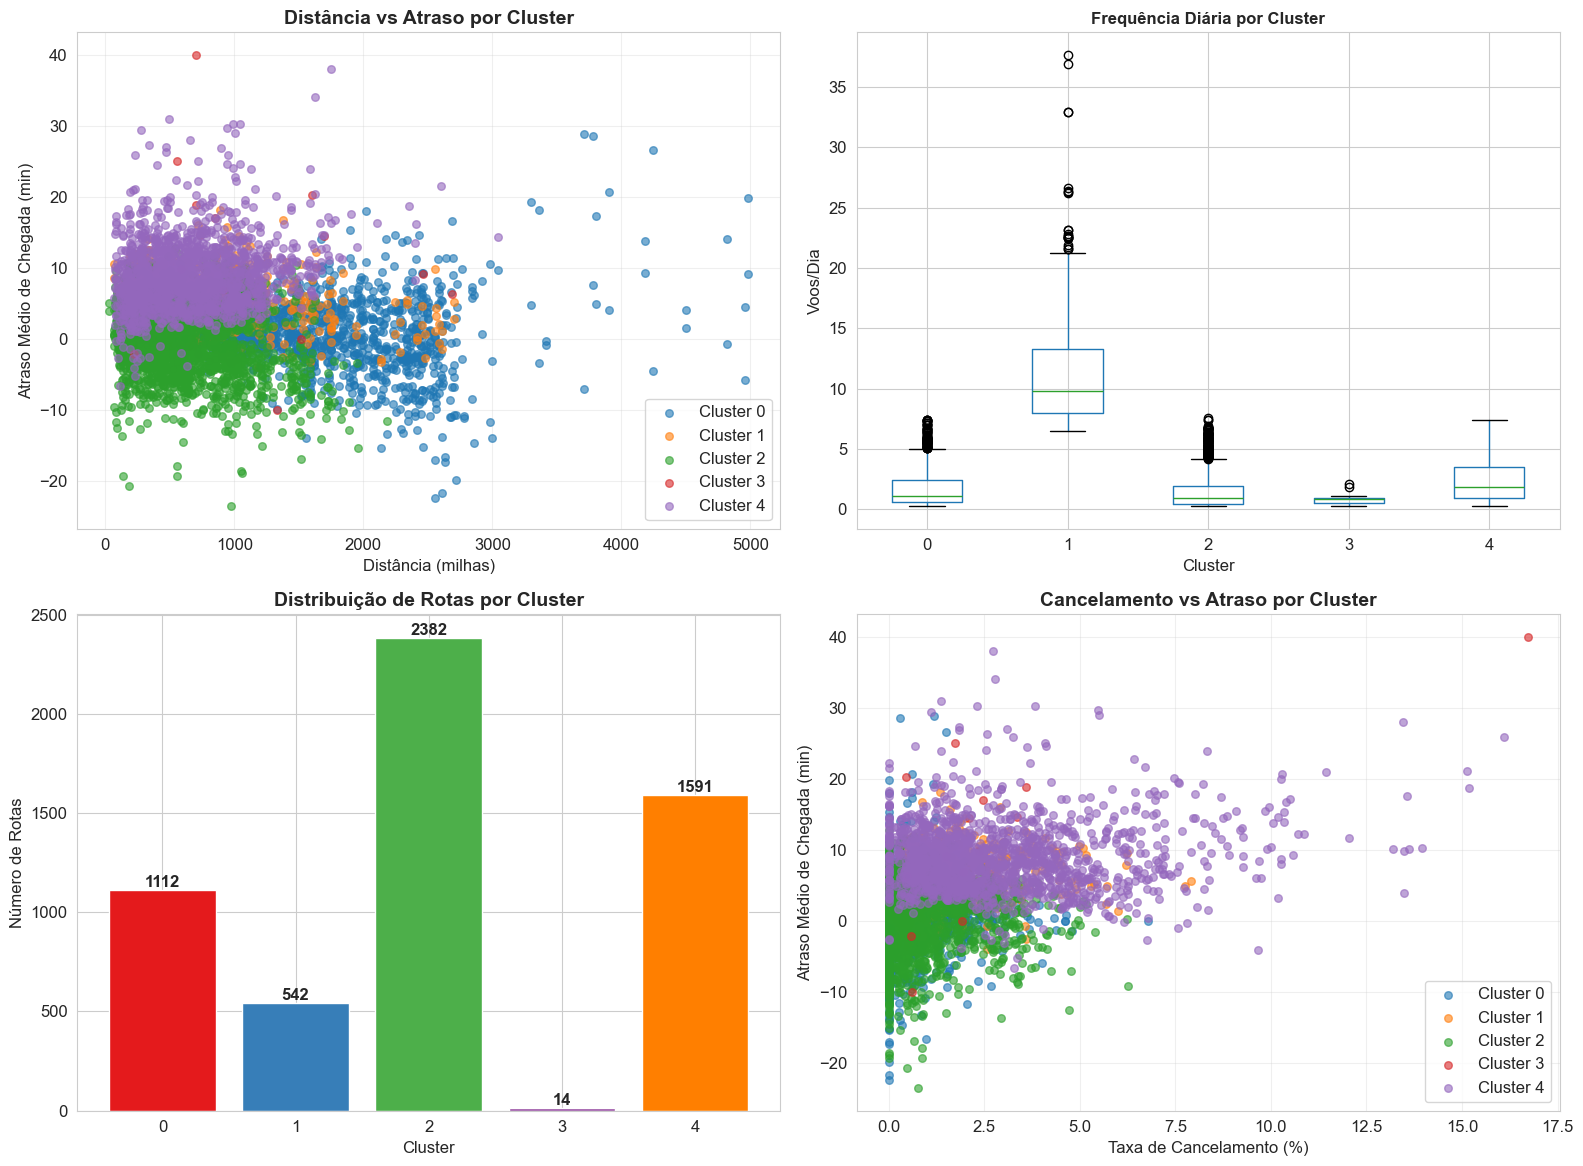


EXEMPLOS DE ROTAS POR CLUSTER

🔵 CLUSTER 0 (1112 rotas):
   Distância média: 1744 milhas
   Atraso médio: 0.30 min
   Frequência média: 1.80 voos/dia
   Top rotas: PHX-DTW, OGG-LAX, FLL-DFW

🔵 CLUSTER 1 (542 rotas):
   Distância média: 799 milhas
   Atraso médio: 5.02 min
   Frequência média: 11.36 voos/dia
   Top rotas: SFO-LAX, LAX-SFO, JFK-LAX

🔵 CLUSTER 2 (2382 rotas):
   Distância média: 602 milhas
   Atraso médio: 0.19 min
   Frequência média: 1.51 voos/dia
   Top rotas: SEA-SNA, SJC-SNA, SNA-SJC

🔵 CLUSTER 3 (14 rotas):
   Distância média: 1183 milhas
   Atraso médio: 12.13 min
   Frequência média: 0.90 voos/dia
   Top rotas: LAX-ASE, SLC-SUN, IAH-ASE

🔵 CLUSTER 4 (1591 rotas):
   Distância média: 667 milhas
   Atraso médio: 8.87 min
   Frequência média: 2.40 voos/dia
   Top rotas: CID-ORD, DAY-ORD, LGA-CLE


In [19]:
# Visualização e análise dos clusters de rotas
print("\n" + "=" * 60)
print("VISUALIZAÇÃO E ANÁLISE DOS CLUSTERS - ROTAS")
print("=" * 60)

route_labels = route_models[best_route_model]['labels']

# Visualização PCA
pca_routes = plot_clusters_pca(X_routes, route_labels, title=f"Rotas ({best_route_model})")

# Adicionar labels ao dataframe
route_features_filtered = route_features_filtered.copy()
route_features_filtered['Cluster'] = route_labels

# Estatísticas por cluster
summary_route_cols = ['TOTAL_FLIGHTS', 'DISTANCE', 'AVG_ARR_DELAY', 'CANCELLATION_RATE', 'DAILY_FREQUENCY']
route_summary = route_features_filtered.groupby('Cluster')[summary_route_cols].mean().round(2)
print("\nEstatísticas médias por cluster:")
display(route_summary)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distância vs Atraso por cluster
ax1 = axes[0, 0]
for cluster_id in sorted(route_features_filtered['Cluster'].unique()):
    if cluster_id != -1:
        cluster_data = route_features_filtered[route_features_filtered['Cluster'] == cluster_id]
        ax1.scatter(cluster_data['DISTANCE'], cluster_data['AVG_ARR_DELAY'], 
                   label=f'Cluster {cluster_id}', alpha=0.6, s=30)
ax1.set_xlabel('Distância (milhas)', fontsize=12)
ax1.set_ylabel('Atraso Médio de Chegada (min)', fontsize=12)
ax1.set_title('Distância vs Atraso por Cluster', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Frequência por cluster
ax2 = axes[0, 1]
route_features_filtered.boxplot(column='DAILY_FREQUENCY', by='Cluster', ax=ax2)
ax2.set_title('Frequência Diária por Cluster', fontsize=12, fontweight='bold')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Voos/Dia')
plt.suptitle('')

# 3. Distribuição de clusters
ax3 = axes[1, 0]
cluster_counts = route_features_filtered['Cluster'].value_counts().sort_index()
ax3.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.Set1(range(len(cluster_counts))))
ax3.set_xlabel('Cluster', fontsize=12)
ax3.set_ylabel('Número de Rotas', fontsize=12)
ax3.set_title('Distribuição de Rotas por Cluster', fontsize=14, fontweight='bold')
for i, v in enumerate(cluster_counts.values):
    ax3.text(cluster_counts.index[i], v, str(v), ha='center', va='bottom', fontweight='bold')

# 4. Cancelamento vs Atraso
ax4 = axes[1, 1]
for cluster_id in sorted(route_features_filtered['Cluster'].unique()):
    if cluster_id != -1:
        cluster_data = route_features_filtered[route_features_filtered['Cluster'] == cluster_id]
        ax4.scatter(cluster_data['CANCELLATION_RATE'], cluster_data['AVG_ARR_DELAY'], 
                   label=f'Cluster {cluster_id}', alpha=0.6, s=30)
ax4.set_xlabel('Taxa de Cancelamento (%)', fontsize=12)
ax4.set_ylabel('Atraso Médio de Chegada (min)', fontsize=12)
ax4.set_title('Cancelamento vs Atraso por Cluster', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Exemplos de rotas por cluster
print("\n" + "=" * 60)
print("EXEMPLOS DE ROTAS POR CLUSTER")
print("=" * 60)

for cluster_id in sorted(route_features_filtered['Cluster'].unique()):
    if cluster_id != -1:
        cluster_routes = route_features_filtered[route_features_filtered['Cluster'] == cluster_id]
        print(f"\n🔵 CLUSTER {cluster_id} ({len(cluster_routes)} rotas):")
        print(f"   Distância média: {cluster_routes['DISTANCE'].mean():.0f} milhas")
        print(f"   Atraso médio: {cluster_routes['AVG_ARR_DELAY'].mean():.2f} min")
        print(f"   Frequência média: {cluster_routes['DAILY_FREQUENCY'].mean():.2f} voos/dia")
        print(f"   Top rotas: {', '.join(cluster_routes.nlargest(3, 'TOTAL_FLIGHTS')['ROUTE'].tolist())}")

### 5.4 Clusterização de Companhias Aéreas

Vamos segmentar as companhias aéreas por perfil operacional:
- Market share e volume de operações
- Performance de pontualidade
- Taxa de cancelamento
- Cobertura de mercado (aeroportos e rotas)
- Tipos de atraso predominantes

In [20]:
# =============================================================================
# CLUSTERIZAÇÃO DE COMPANHIAS AÉREAS
# =============================================================================

print("=" * 60)
print("CLUSTERIZAÇÃO DE COMPANHIAS AÉREAS")
print("=" * 60)

print(f"\nTotal de companhias aéreas: {len(airline_features)}")

# Selecionar features para clusterização
airline_cluster_features = [
    'TOTAL_FLIGHTS',
    'MARKET_SHARE',
    'CANCELLATION_RATE',
    'DIVERSION_RATE',
    'AVG_DEP_DELAY',
    'STD_DEP_DELAY',
    'AVG_ARR_DELAY',
    'STD_ARR_DELAY',
    'AVG_DISTANCE',
    'NUM_AIRPORTS_SERVED',
    'NUM_ROUTES',
    'PCT_AIRLINE_DELAY',
    'PCT_WEATHER_DELAY',
    'PCT_LATE_AIRCRAFT_DELAY',
    'DELAY_VARIABILITY'
]

# Verificar features disponíveis
available_airline_features = [f for f in airline_cluster_features if f in airline_features.columns]
print(f"\nFeatures selecionadas: {len(available_airline_features)}")

# Pré-processamento
X_airlines, scaler_airlines, _ = preprocess_for_clustering(
    airline_features, 
    available_airline_features, 
    scaler_type='standard'  # Standard para dataset pequeno
)

print(f"✅ Dados pré-processados: {X_airlines.shape}")

CLUSTERIZAÇÃO DE COMPANHIAS AÉREAS

Total de companhias aéreas: 14

Features selecionadas: 15
✅ Dados pré-processados: (14, 15)



DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS - COMPANHIAS AÉREAS


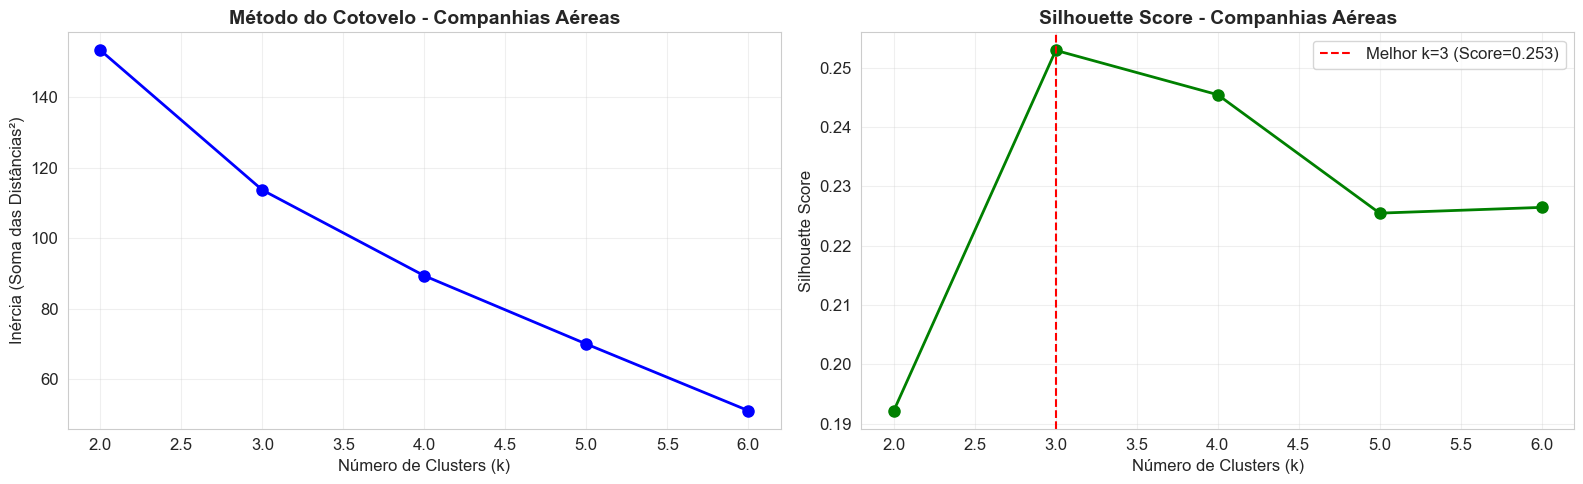


📊 Número ótimo de clusters sugerido: 3


In [21]:
# Determinação do número ótimo de clusters - Companhias Aéreas
print("\n" + "=" * 60)
print("DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS - COMPANHIAS AÉREAS")
print("=" * 60)

# Como temos apenas 14 companhias, testar até 6 clusters
max_k_airlines = min(6, len(airline_features) - 1)
k_range_airlines, inertias_airlines, silhouettes_airlines = find_optimal_clusters_elbow(
    X_airlines, max_clusters=max_k_airlines
)

optimal_k_airlines = plot_elbow_silhouette(
    k_range_airlines, inertias_airlines, silhouettes_airlines, title="Companhias Aéreas"
)

print(f"\n📊 Número ótimo de clusters sugerido: {optimal_k_airlines}")

In [22]:
# Treinar modelos - Companhias Aéreas
print("\n" + "=" * 60)
print("TREINAMENTO DOS MODELOS - COMPANHIAS AÉREAS")
print("=" * 60)

n_clusters_airlines = optimal_k_airlines if optimal_k_airlines >= 2 else 3

print(f"\nUsando {n_clusters_airlines} clusters")

# Treinar modelos
airline_models = train_clustering_models(X_airlines, n_clusters_airlines)

# Avaliar modelos
airline_evaluation = evaluate_clustering(X_airlines, airline_models)

print("\n📊 AVALIAÇÃO DOS MODELOS - COMPANHIAS AÉREAS:")
display(airline_evaluation.sort_values('Silhouette_Score', ascending=False))

# Melhor modelo
best_airline_model = airline_evaluation.loc[airline_evaluation['Silhouette_Score'].idxmax(), 'Modelo']
print(f"\n🏆 Melhor modelo para Companhias Aéreas: {best_airline_model}")


TREINAMENTO DOS MODELOS - COMPANHIAS AÉREAS

Usando 3 clusters

📊 AVALIAÇÃO DOS MODELOS - COMPANHIAS AÉREAS:


,Modelo,N_Clusters,N_Outliers,Silhouette_Score,Davies_Bouldin,Calinski_Harabasz
0,KMeans,3,0,0.252905,1.090318,4.662713
1,GMM,3,0,0.252905,1.090318,4.662713
2,Hierarchical,3,0,0.252905,1.090318,4.662713
3,DBSCAN,1,0,0.000000,inf,0.000000



🏆 Melhor modelo para Companhias Aéreas: KMeans



VISUALIZAÇÃO E ANÁLISE DOS CLUSTERS - COMPANHIAS AÉREAS


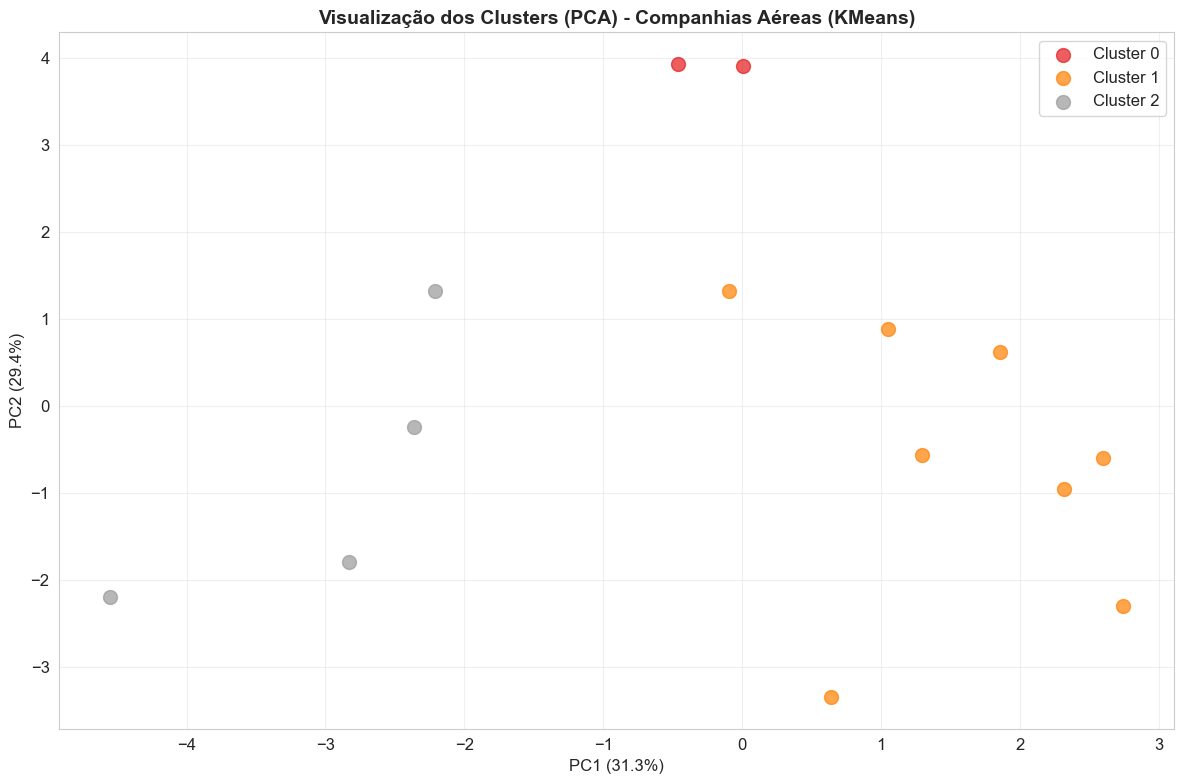


📊 COMPANHIAS AÉREAS POR CLUSTER:


,AIRLINE_x,AIRLINE_y,Cluster,TOTAL_FLIGHTS,MARKET_SHARE,AVG_ARR_DELAY,CANCELLATION_RATE,NUM_AIRPORTS_SERVED
8,NK,Spirit Air Lines,0,117379,2.017141,14.471800,1.707290,98
5,F9,Frontier Airlines Inc.,0,90836,1.561003,12.504706,0.647320,155
13,WN,Southwest Airlines Co.,1,1261855,21.684789,4.374964,1.271382,258
3,DL,Delta Air Lines Inc.,1,875881,15.051884,0.186754,0.436589,440
0,AA,American Airlines Inc.,1,725984,12.475926,3.451372,1.504028,276
9,OO,Skywest Airlines Inc.,1,588353,10.110758,5.845652,1.692861,546
4,EV,Atlantic Southeast Airlines,1,571977,9.829339,6.585379,2.662869,491
10,UA,United Air Lines Inc.,1,515723,8.862622,5.431594,1.274521,261
7,MQ,American Eagle Airlines Inc.,1,294632,5.063207,6.457873,5.099582,351
2,B6,JetBlue Airways,1,267048,4.589180,6.677861,1.601210,184


In [24]:
# Visualização e análise dos clusters de companhias aéreas
print("\n" + "=" * 60)
print("VISUALIZAÇÃO E ANÁLISE DOS CLUSTERS - COMPANHIAS AÉREAS")
print("=" * 60)

airline_labels = airline_models[best_airline_model]['labels']

# Visualização PCA
pca_airlines = plot_clusters_pca(X_airlines, airline_labels, title=f"Companhias Aéreas ({best_airline_model})")

# Adicionar labels ao dataframe
airline_features['Cluster'] = airline_labels

# Tabela completa de companhias por cluster
print("\n📊 COMPANHIAS AÉREAS POR CLUSTER:")
display(airline_features[['AIRLINE_x', 'AIRLINE_y', 'Cluster', 'TOTAL_FLIGHTS', 'MARKET_SHARE', 
                           'AVG_ARR_DELAY', 'CANCELLATION_RATE', 'NUM_AIRPORTS_SERVED']].sort_values(['Cluster', 'TOTAL_FLIGHTS'], ascending=[True, False]))

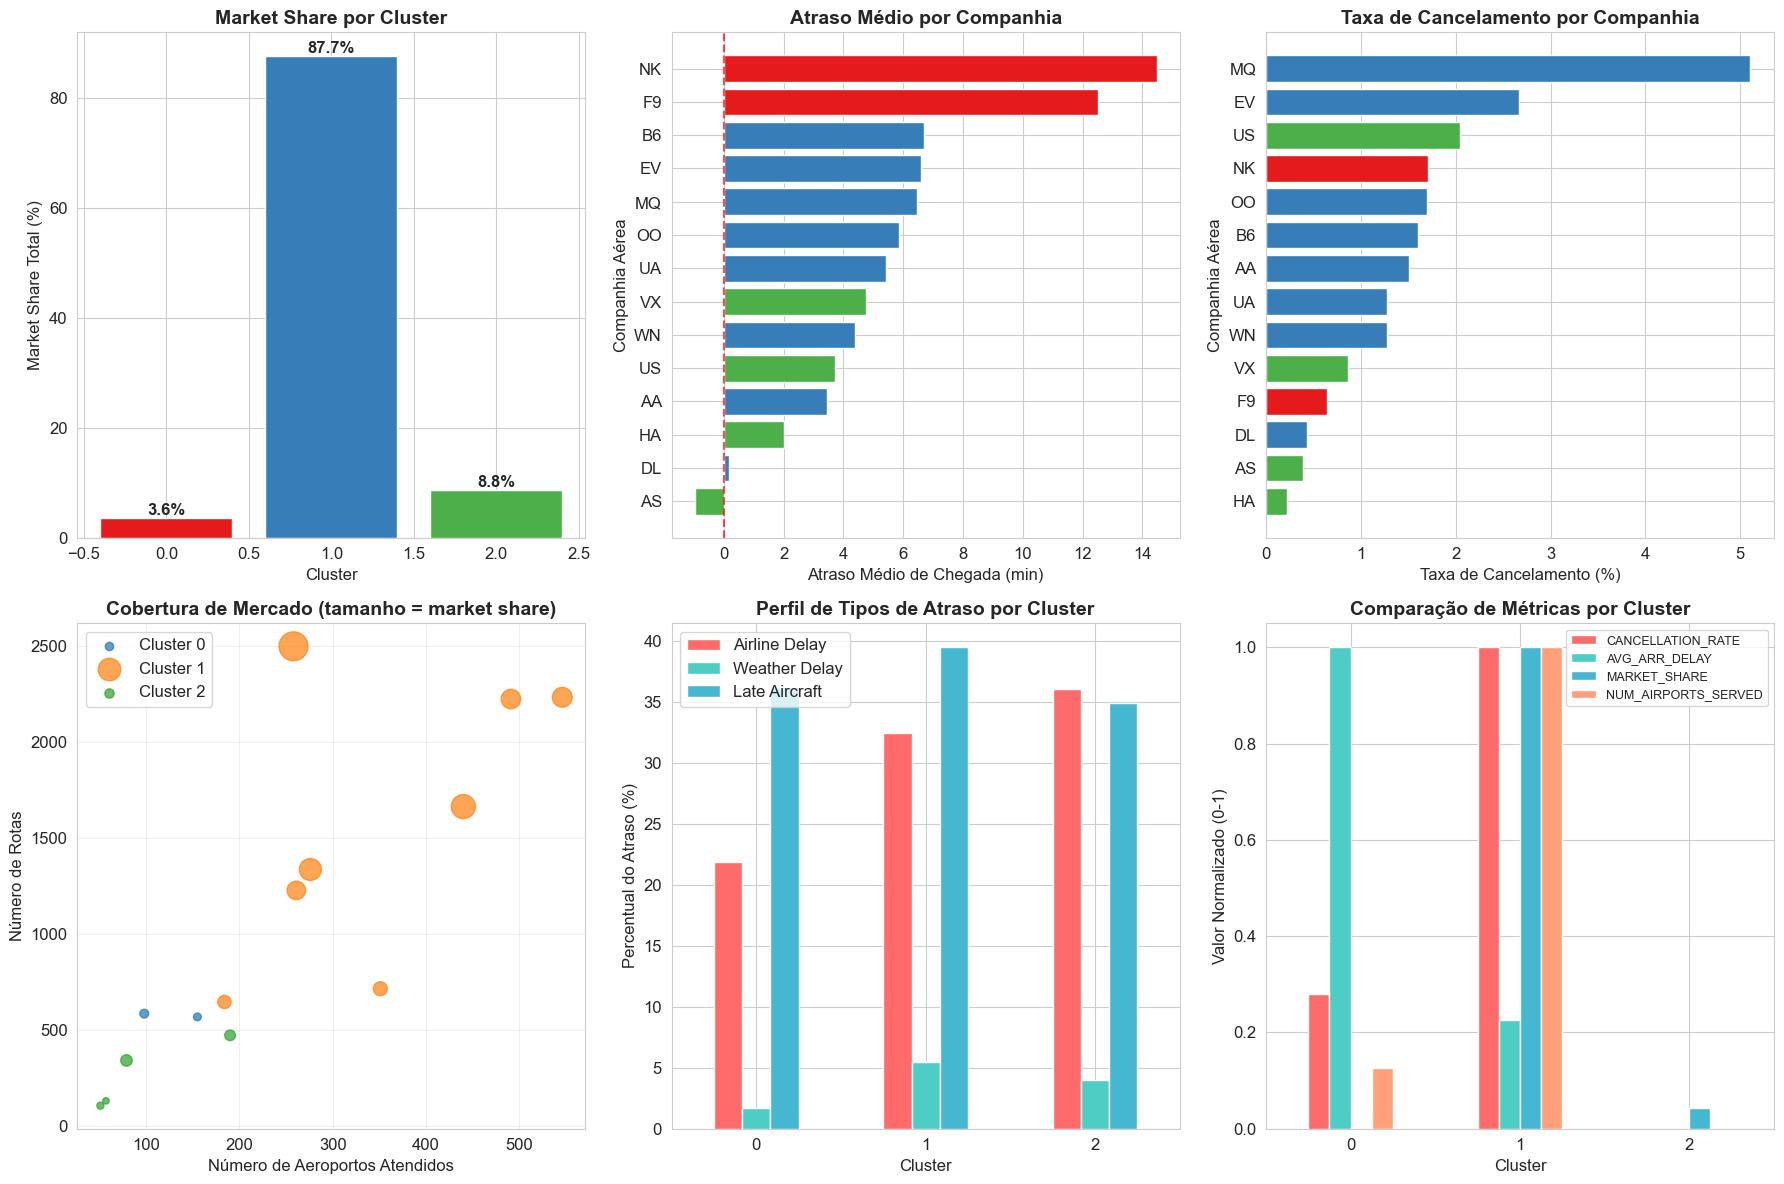


PERFIL DOS CLUSTERS DE COMPANHIAS AÉREAS

🔵 CLUSTER 0:
   Companhias: F9, NK
   Market Share Total: 3.6%
   Atraso Médio: 13.49 min
   Taxa de Cancelamento: 1.18%
   Aeroportos Atendidos (média): 126

🔵 CLUSTER 1:
   Companhias: AA, B6, DL, EV, MQ, OO, UA, WN
   Market Share Total: 87.7%
   Atraso Médio: 4.88 min
   Taxa de Cancelamento: 1.94%
   Aeroportos Atendidos (média): 351

🔵 CLUSTER 2:
   Companhias: AS, HA, US, VX
   Market Share Total: 8.8%
   Atraso Médio: 2.37 min
   Taxa de Cancelamento: 0.88%
   Aeroportos Atendidos (média): 94


In [28]:
# Análise detalhada das companhias aéreas por cluster
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Market Share por Cluster
ax1 = axes[0, 0]
cluster_market = airline_features.groupby('Cluster')['MARKET_SHARE'].sum()
colors = plt.cm.Set1(range(len(cluster_market)))
ax1.bar(cluster_market.index, cluster_market.values, color=colors)
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Market Share Total (%)', fontsize=12)
ax1.set_title('Market Share por Cluster', fontsize=14, fontweight='bold')
for i, v in enumerate(cluster_market.values):
    ax1.text(cluster_market.index[i], v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Atraso Médio por Companhia (colorido por cluster)
ax2 = axes[0, 1]
sorted_airlines = airline_features.sort_values('AVG_ARR_DELAY', ascending=True)
colors_bars = [plt.cm.Set1(c) for c in sorted_airlines['Cluster']]
ax2.barh(sorted_airlines['AIRLINE_x'], sorted_airlines['AVG_ARR_DELAY'], color=colors_bars)
ax2.set_xlabel('Atraso Médio de Chegada (min)', fontsize=12)
ax2.set_ylabel('Companhia Aérea', fontsize=12)
ax2.set_title('Atraso Médio por Companhia', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 3. Taxa de Cancelamento por Companhia
ax3 = axes[0, 2]
sorted_cancel = airline_features.sort_values('CANCELLATION_RATE', ascending=True)
colors_cancel = [plt.cm.Set1(c) for c in sorted_cancel['Cluster']]
ax3.barh(sorted_cancel['AIRLINE_x'], sorted_cancel['CANCELLATION_RATE'], color=colors_cancel)
ax3.set_xlabel('Taxa de Cancelamento (%)', fontsize=12)
ax3.set_ylabel('Companhia Aérea', fontsize=12)
ax3.set_title('Taxa de Cancelamento por Companhia', fontsize=14, fontweight='bold')

# 4. Número de Aeroportos vs Rotas (por cluster)
ax4 = axes[1, 0]
for cluster_id in sorted(airline_features['Cluster'].unique()):
    if cluster_id != -1:
        cluster_data = airline_features[airline_features['Cluster'] == cluster_id]
        ax4.scatter(cluster_data['NUM_AIRPORTS_SERVED'], cluster_data['NUM_ROUTES'], 
                   label=f'Cluster {cluster_id}', s=cluster_data['MARKET_SHARE']*20, alpha=0.7)
ax4.set_xlabel('Número de Aeroportos Atendidos', fontsize=12)
ax4.set_ylabel('Número de Rotas', fontsize=12)
ax4.set_title('Cobertura de Mercado (tamanho = market share)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Perfil de Atrasos por Cluster
ax5 = axes[1, 1]
delay_profile = airline_features.groupby('Cluster')[['PCT_AIRLINE_DELAY', 'PCT_WEATHER_DELAY', 'PCT_LATE_AIRCRAFT_DELAY']].mean()
delay_profile.plot(kind='bar', ax=ax5, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax5.set_xlabel('Cluster', fontsize=12)
ax5.set_ylabel('Percentual do Atraso (%)', fontsize=12)
ax5.set_title('Perfil de Tipos de Atraso por Cluster', fontsize=14, fontweight='bold')
ax5.legend(['Airline Delay', 'Weather Delay', 'Late Aircraft'])
ax5.tick_params(axis='x', rotation=0)

# 6. Radar chart simplificado - Métricas médias por cluster
ax6 = axes[1, 2]
cluster_means = airline_features.groupby('Cluster')[['CANCELLATION_RATE', 'AVG_ARR_DELAY', 'MARKET_SHARE', 'NUM_AIRPORTS_SERVED']].mean()
cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
cluster_means_normalized.plot(kind='bar', ax=ax6, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
ax6.set_xlabel('Cluster', fontsize=12)
ax6.set_ylabel('Valor Normalizado (0-1)', fontsize=12)
ax6.set_title('Comparação de Métricas por Cluster', fontsize=14, fontweight='bold')
ax6.legend(loc='upper right', fontsize=9)
ax6.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Resumo textual dos clusters
print("\n" + "=" * 60)
print("PERFIL DOS CLUSTERS DE COMPANHIAS AÉREAS")
print("=" * 60)

for cluster_id in sorted(airline_features['Cluster'].unique()):
    if cluster_id != -1:
        cluster_airlines = airline_features[airline_features['Cluster'] == cluster_id]
        print(f"\n🔵 CLUSTER {cluster_id}:")
        print(f"   Companhias: {', '.join(cluster_airlines['AIRLINE_x'].tolist())}")
        print(f"   Market Share Total: {cluster_airlines['MARKET_SHARE'].sum():.1f}%")
        print(f"   Atraso Médio: {cluster_airlines['AVG_ARR_DELAY'].mean():.2f} min")
        print(f"   Taxa de Cancelamento: {cluster_airlines['CANCELLATION_RATE'].mean():.2f}%")
        print(f"   Aeroportos Atendidos (média): {cluster_airlines['NUM_AIRPORTS_SERVED'].mean():.0f}")

## 6. Análise Hierárquica - Dendrogramas

Vamos criar dendrogramas para visualizar a estrutura hierárquica dos clusters e validar os agrupamentos encontrados.

ANÁLISE HIERÁRQUICA - DENDROGRAMAS


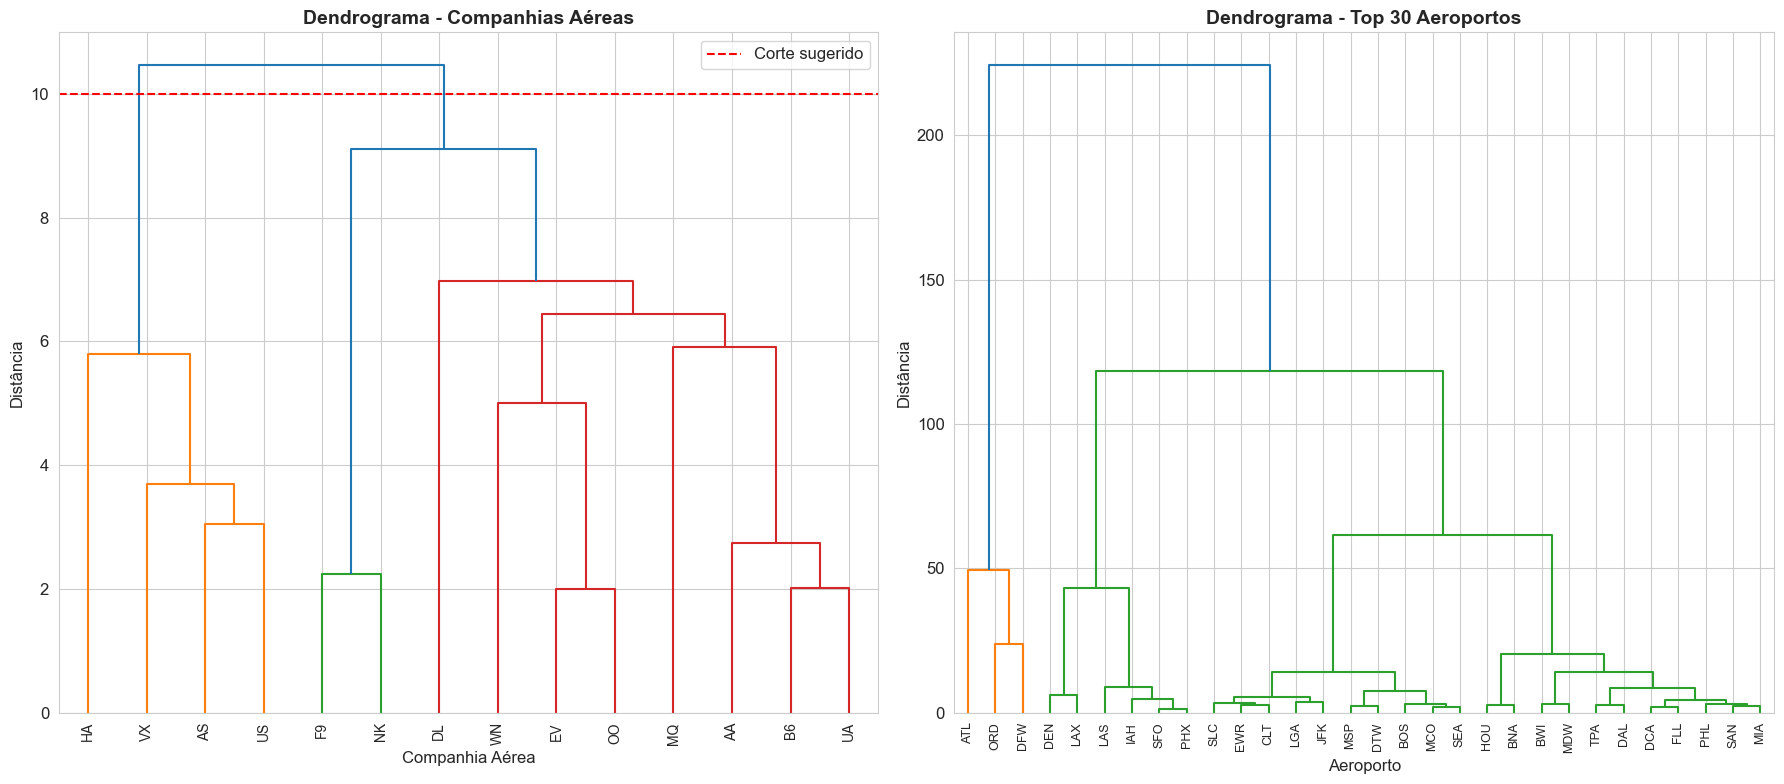


✅ Dendrogramas gerados com sucesso!
   Os dendrogramas mostram a estrutura hierárquica dos clusters.
   A linha vermelha indica um possível ponto de corte para definir clusters.


In [30]:
# Dendrograma para Companhias Aéreas
print("=" * 60)
print("ANÁLISE HIERÁRQUICA - DENDROGRAMAS")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Dendrograma - Companhias Aéreas
ax1 = axes[0]
linkage_airlines = linkage(X_airlines, method='ward')
dendrogram(linkage_airlines, labels=airline_features['AIRLINE_x'].values, ax=ax1, 
           leaf_rotation=90, leaf_font_size=10)
ax1.set_title('Dendrograma - Companhias Aéreas', fontsize=14, fontweight='bold')
ax1.set_xlabel('Companhia Aérea', fontsize=12)
ax1.set_ylabel('Distância', fontsize=12)
ax1.axhline(y=10, color='red', linestyle='--', label='Corte sugerido')
ax1.legend()

# 2. Dendrograma - Aeroportos (amostra dos top 30)
ax2 = axes[1]
# Usar apenas os 30 maiores aeroportos para visualização
top_airports = airport_features.nlargest(30, 'TOTAL_FLIGHTS')
X_top_airports = scaler_airports.transform(top_airports[available_features].fillna(0))
linkage_airports = linkage(X_top_airports, method='ward')
dendrogram(linkage_airports, labels=top_airports['AIRPORT'].values, ax=ax2,
           leaf_rotation=90, leaf_font_size=9)
ax2.set_title('Dendrograma - Top 30 Aeroportos', fontsize=14, fontweight='bold')
ax2.set_xlabel('Aeroporto', fontsize=12)
ax2.set_ylabel('Distância', fontsize=12)

plt.tight_layout()
plt.show()

print("\n✅ Dendrogramas gerados com sucesso!")
print("   Os dendrogramas mostram a estrutura hierárquica dos clusters.")
print("   A linha vermelha indica um possível ponto de corte para definir clusters.")

## 7. Comparação Final e Resumo dos Modelos

In [31]:
# Comparação final dos resultados
print("=" * 80)
print("RESUMO FINAL - MODELOS DE CLUSTERIZAÇÃO")
print("=" * 80)

# Criar tabela resumo
summary_data = []

# Aeroportos
best_airport_score = airport_evaluation.loc[airport_evaluation['Silhouette_Score'].idxmax()]
summary_data.append({
    'Entidade': 'Aeroportos',
    'Total_Itens': len(airport_features),
    'Melhor_Modelo': best_airport_model,
    'N_Clusters': int(best_airport_score['N_Clusters']),
    'Silhouette_Score': best_airport_score['Silhouette_Score'],
    'Davies_Bouldin': best_airport_score['Davies_Bouldin']
})

# Rotas
best_route_score = route_evaluation.loc[route_evaluation['Silhouette_Score'].idxmax()]
summary_data.append({
    'Entidade': 'Rotas',
    'Total_Itens': len(route_features_filtered),
    'Melhor_Modelo': best_route_model,
    'N_Clusters': int(best_route_score['N_Clusters']),
    'Silhouette_Score': best_route_score['Silhouette_Score'],
    'Davies_Bouldin': best_route_score['Davies_Bouldin']
})

# Companhias Aéreas
best_airline_score = airline_evaluation.loc[airline_evaluation['Silhouette_Score'].idxmax()]
summary_data.append({
    'Entidade': 'Companhias Aéreas',
    'Total_Itens': len(airline_features),
    'Melhor_Modelo': best_airline_model,
    'N_Clusters': int(best_airline_score['N_Clusters']),
    'Silhouette_Score': best_airline_score['Silhouette_Score'],
    'Davies_Bouldin': best_airline_score['Davies_Bouldin']
})

summary_df = pd.DataFrame(summary_data)
print("\n📊 TABELA COMPARATIVA DOS MELHORES MODELOS:")
display(summary_df)

# Interpretação das métricas
print("\n" + "=" * 80)
print("INTERPRETAÇÃO DAS MÉTRICAS")
print("=" * 80)
print("""
📈 Silhouette Score: Mede a qualidade dos clusters (-1 a 1)
   • Valores > 0.5: Clusters bem definidos
   • Valores 0.25 a 0.5: Clusters razoáveis
   • Valores < 0.25: Clusters podem estar sobrepostos

📉 Davies-Bouldin Index: Mede a separação entre clusters (menor é melhor)
   • Valores < 1: Boa separação entre clusters
   • Valores > 2: Clusters podem estar muito próximos
""")

RESUMO FINAL - MODELOS DE CLUSTERIZAÇÃO

📊 TABELA COMPARATIVA DOS MELHORES MODELOS:


,Entidade,Total_Itens,Melhor_Modelo,N_Clusters,Silhouette_Score,Davies_Bouldin
0,Aeroportos,930,KMeans,4,0.733767,0.603555
1,Rotas,5641,KMeans,5,0.175068,1.449678
2,Companhias Aéreas,14,KMeans,3,0.252905,1.090318



INTERPRETAÇÃO DAS MÉTRICAS

📈 Silhouette Score: Mede a qualidade dos clusters (-1 a 1)
   • Valores > 0.5: Clusters bem definidos
   • Valores 0.25 a 0.5: Clusters razoáveis
   • Valores < 0.25: Clusters podem estar sobrepostos

📉 Davies-Bouldin Index: Mede a separação entre clusters (menor é melhor)
   • Valores < 1: Boa separação entre clusters
   • Valores > 2: Clusters podem estar muito próximos



## 8. Salvamento dos Modelos e Resultados

In [32]:
# Salvamento dos modelos e resultados
import pickle
import json

print("=" * 60)
print("SALVAMENTO DOS MODELOS E RESULTADOS")
print("=" * 60)

# Criar diretório para modelos
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# 1. Salvar modelos de clusterização
clustering_models = {
    'airports': {
        'model': airport_models[best_airport_model]['model'],
        'scaler': scaler_airports,
        'features': available_features,
        'best_model_name': best_airport_model,
        'n_clusters': n_clusters_airports
    },
    'routes': {
        'model': route_models[best_route_model]['model'],
        'scaler': scaler_routes,
        'features': available_route_features,
        'best_model_name': best_route_model,
        'n_clusters': n_clusters_routes
    },
    'airlines': {
        'model': airline_models[best_airline_model]['model'],
        'scaler': scaler_airlines,
        'features': available_airline_features,
        'best_model_name': best_airline_model,
        'n_clusters': n_clusters_airlines
    }
}

# Salvar modelos
with open(f'{models_dir}/clustering_models.pkl', 'wb') as f:
    pickle.dump(clustering_models, f)
print(f"✓ Modelos salvos em: {models_dir}/clustering_models.pkl")

# 2. Salvar datasets com clusters
airport_features.to_csv(f'{models_dir}/airports_clustered.csv', index=False)
print(f"✓ Aeroportos clusterizados: {models_dir}/airports_clustered.csv")

route_features_filtered.to_csv(f'{models_dir}/routes_clustered.csv', index=False)
print(f"✓ Rotas clusterizadas: {models_dir}/routes_clustered.csv")

airline_features.to_csv(f'{models_dir}/airlines_clustered.csv', index=False)
print(f"✓ Companhias clusterizadas: {models_dir}/airlines_clustered.csv")

# 3. Salvar metadados
metadata = {
    'date_created': pd.Timestamp.now().isoformat(),
    'models': {
        'airports': {
            'algorithm': best_airport_model,
            'n_clusters': int(n_clusters_airports),
            'silhouette_score': float(best_airport_score['Silhouette_Score']),
            'n_features': len(available_features),
            'n_samples': len(airport_features)
        },
        'routes': {
            'algorithm': best_route_model,
            'n_clusters': int(n_clusters_routes),
            'silhouette_score': float(best_route_score['Silhouette_Score']),
            'n_features': len(available_route_features),
            'n_samples': len(route_features_filtered)
        },
        'airlines': {
            'algorithm': best_airline_model,
            'n_clusters': int(n_clusters_airlines),
            'silhouette_score': float(best_airline_score['Silhouette_Score']),
            'n_features': len(available_airline_features),
            'n_samples': len(airline_features)
        }
    }
}

with open(f'{models_dir}/clustering_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Metadados salvos: {models_dir}/clustering_metadata.json")

print("\n✅ Todos os modelos e resultados foram salvos com sucesso!")

SALVAMENTO DOS MODELOS E RESULTADOS
✓ Modelos salvos em: ../models/clustering_models.pkl
✓ Aeroportos clusterizados: ../models/airports_clustered.csv
✓ Rotas clusterizadas: ../models/routes_clustered.csv
✓ Companhias clusterizadas: ../models/airlines_clustered.csv
✓ Metadados salvos: ../models/clustering_metadata.json

✅ Todos os modelos e resultados foram salvos com sucesso!


In [33]:
# Exemplo de como usar os modelos para classificar novos dados
print("=" * 60)
print("EXEMPLO DE USO - CLASSIFICAÇÃO DE NOVO AEROPORTO")
print("=" * 60)

# Função para classificar um novo aeroporto
def predict_airport_cluster(airport_data, model_dict):
    """
    Classifica um aeroporto em um cluster baseado em suas características.
    
    Args:
        airport_data: Dict com as features do aeroporto
        model_dict: Dicionário com modelo e scaler
    
    Returns:
        Cluster previsto
    """
    # Criar DataFrame com as features
    df_new = pd.DataFrame([airport_data])
    
    # Garantir que todas as features estão presentes
    for feat in model_dict['features']:
        if feat not in df_new.columns:
            df_new[feat] = 0
    
    # Selecionar apenas as features usadas no treinamento
    X_new = df_new[model_dict['features']].values
    
    # Normalizar
    X_scaled = model_dict['scaler'].transform(X_new)
    
    # Prever cluster
    if hasattr(model_dict['model'], 'predict'):
        cluster = model_dict['model'].predict(X_scaled)[0]
    else:
        # Para modelos como GMM
        cluster = model_dict['model'].predict(X_scaled)[0]
    
    return cluster


# Exemplo: classificar um aeroporto hipotético
novo_aeroporto = {
    'TOTAL_FLIGHTS': 50000,
    'CANCELLATION_RATE': 1.5,
    'DIVERSION_RATE': 0.2,
    'AVG_DEP_DELAY': 8.5,
    'STD_DEP_DELAY': 25.0,
    'AVG_ARR_DELAY': 5.2,
    'AVG_TAXI_OUT': 15.0,
    'AVG_DISTANCE': 900,
    'NUM_AIRLINES': 8,
    'NUM_DESTINATIONS': 50,
    'PCT_WEATHER_DELAY': 15.0,
    'PCT_AIRLINE_DELAY': 35.0
}

# Carregar modelo salvo e fazer previsão
with open(f'{models_dir}/clustering_models.pkl', 'rb') as f:
    loaded_models = pickle.load(f)

cluster_previsto = predict_airport_cluster(novo_aeroporto, loaded_models['airports'])

print(f"\n📍 Características do novo aeroporto:")
for key, value in novo_aeroporto.items():
    print(f"   {key}: {value}")

print(f"\n🎯 Cluster previsto: {cluster_previsto}")

# Comparar com aeroportos do mesmo cluster
aeroportos_mesmo_cluster = airport_features[airport_features['Cluster'] == cluster_previsto]
print(f"\n📊 Aeroportos similares no mesmo cluster:")
print(f"   Total: {len(aeroportos_mesmo_cluster)} aeroportos")
print(f"   Exemplos: {', '.join(aeroportos_mesmo_cluster['AIRPORT'].head(5).tolist())}")

EXEMPLO DE USO - CLASSIFICAÇÃO DE NOVO AEROPORTO

📍 Características do novo aeroporto:
   TOTAL_FLIGHTS: 50000
   CANCELLATION_RATE: 1.5
   DIVERSION_RATE: 0.2
   AVG_DEP_DELAY: 8.5
   STD_DEP_DELAY: 25.0
   AVG_ARR_DELAY: 5.2
   AVG_TAXI_OUT: 15.0
   AVG_DISTANCE: 900
   NUM_AIRLINES: 8
   NUM_DESTINATIONS: 50
   PCT_WEATHER_DELAY: 15.0
   PCT_AIRLINE_DELAY: 35.0

🎯 Cluster previsto: 2

📊 Aeroportos similares no mesmo cluster:
   Total: 24 aeroportos
   Exemplos: BOS, BWI, CLT, DAL, DCA


## 9. Conclusões e Insights

### 9.1 Síntese da Análise de Clusterização

Este notebook implementou um pipeline completo de clusterização para segmentar três entidades do setor aéreo: **aeroportos**, **rotas** e **companhias aéreas**. O algoritmo **K-Means** demonstrou o melhor desempenho para todas as entidades, identificando padrões operacionais distintos que podem ser utilizados para tomada de decisão estratégica.

### 9.2 Resultados Obtidos

| Entidade | Itens Analisados | Clusters | Silhouette Score | Qualidade |
|----------|------------------|----------|------------------|-----------|
| **Aeroportos** | 930 | 4 | **0.734** | ✅ Excelente |
| **Rotas** | 5.641 | 5 | 0.175 | ⚠️ Razoável |
| **Companhias Aéreas** | 14 | 3 | 0.253 | ⚠️ Razoável |

### 9.3 Principais Insights por Entidade

---

#### 🏢 **Aeroportos — 4 Clusters Identificados**

A clusterização de aeroportos obteve o **melhor desempenho** (Silhouette = 0.734), revelando uma segmentação clara:

| Cluster | Qtd | Perfil | Volume Médio | Atraso Médio | Taxa Cancel. | Exemplos |
|---------|-----|--------|--------------|--------------|--------------|----------|
| **0** | 884 | Regionais Eficientes | 2.537 voos | 1.5 min | 1.75% | BNA, PDX, STL, HNL |
| **1** | 5 | Mega Hubs | 252.600 voos | 6.3 min | 1.71% | ATL, ORD, DFW, DEN, LAX |
| **2** | 24 | Grandes Aeroportos | 96.387 voos | 5.0 min | 1.54% | SFO, PHX, IAH, LAS, MSP |
| **3** | 17 | Microaeroportos Problemáticos | 23 voos | 17.8 min | 2.52% | Aeroportos codificados |

**Insights Estratégicos:**
- **Cluster 1 (Mega Hubs)**: Apenas 5 aeroportos concentram altíssimo volume — ATL lidera com maior movimento
- **Cluster 0**: A maioria dos aeroportos (95%) opera em escala regional com boa pontualidade
- **Cluster 3**: Aeroportos com baixíssimo volume e problemas operacionais severos (atraso médio 17.8 min)
- A **taxa de cancelamento** é relativamente uniforme (~1.5-2.5%) entre os clusters

---

#### ✈️ **Rotas — 5 Clusters Identificados**

A segmentação de 5.641 rotas revelou perfis operacionais distintos:

| Cluster | Qtd | Perfil | Distância Média | Atraso Médio | Frequência | Top Rotas |
|---------|-----|--------|-----------------|--------------|------------|-----------|
| **0** | 1.112 | Longa Distância Pontuais | 1.744 mi | **0.3 min** | 1.8/dia | PHX-DTW, OGG-LAX |
| **1** | 542 | Alta Frequência Premium | 799 mi | 5.0 min | **11.4/dia** | SFO-LAX, JFK-LAX |
| **2** | 2.382 | Curta Distância Eficientes | 602 mi | **0.2 min** | 1.5/dia | SEA-SNA, SJC-SNA |
| **3** | 14 | Destinos Turísticos Problemáticos | 1.183 mi | **12.1 min** | 0.9/dia | LAX-ASE, SLC-SUN |
| **4** | 1.591 | Conexões Regionais com Atrasos | 667 mi | 8.9 min | 2.4/dia | CID-ORD, DAY-ORD |

**Insights Estratégicos:**
- **Cluster 1**: Rotas de alta demanda (ex: SFO-LAX) com 11+ voos/dia dominam o mercado
- **Cluster 0 e 2**: Rotas pontuais com atrasos quase zero — oportunidades de expansão
- **Cluster 3**: Apenas 14 rotas com atraso médio de 12 min — destinos de esqui/turísticos (ASE = Aspen)
- **Cluster 4**: Rotas regionais conectando a grandes hubs (ORD) com problemas de atraso

---

#### 🛫 **Companhias Aéreas — 3 Clusters Identificados**

A segmentação das 14 companhias revelou três perfis distintos:

| Cluster | Companhias | Market Share | Atraso Médio | Taxa Cancel. | Perfil |
|---------|------------|--------------|--------------|--------------|--------|
| **0** | F9, NK | **3.6%** | **13.5 min** | 1.18% | Low-Cost com Atrasos |
| **1** | AA, B6, DL, EV, MQ, OO, UA, WN | **87.7%** | 4.9 min | 1.94% | Major Carriers Dominantes |
| **2** | AS, HA, US, VX | **8.8%** | **2.4 min** | **0.88%** | Regionais Premium |

**Insights Estratégicos:**
- **Cluster 1** domina com 87.7% do mercado — inclui Delta (DL), American (AA), United (UA), Southwest (WN)
- **Cluster 0 (F9=Frontier, NK=Spirit)**: Ultra low-cost com piores atrasos (13.5 min) — trade-off preço/qualidade
- **Cluster 2 (AS=Alaska, HA=Hawaiian, VX=Virgin)**: Melhor performance operacional — menor atraso (2.4 min) e cancelamentos (0.88%)
- As companhias de **maior market share têm taxas de cancelamento mais altas** (1.94%)

---

### 9.4 Análise dos Algoritmos

| Algoritmo | Aeroportos | Rotas | Companhias | Observações |
|-----------|------------|-------|------------|-------------|
| **K-Means** | ✅ 0.734 | ✅ 0.175 | ✅ 0.253 | Melhor performance geral |
| **GMM** | 0.728 | 0.167 | 0.222 | Próximo ao K-Means |
| **Hierarchical** | 0.696 | 0.143 | 0.111 | Útil para visualização |
| **DBSCAN** | 0.091 | N/A | N/A | Detectou outliers, mas clusters fracos |

**Conclusão sobre Algoritmos:**
- **K-Means** foi consistentemente o melhor para dados tabulares agregados
- **GMM** apresentou resultados similares, podendo ser alternativa
- **DBSCAN** foi eficaz na detecção de outliers, mas não para segmentação geral
- **Hierarchical** útil para análise exploratória com dendrogramas

---

### 9.5 Aplicações Práticas

#### Para Aeroportos:
- **Benchmarking**: Comparar KPIs entre aeroportos do mesmo cluster
- **Alocação de recursos**: Direcionar investimentos para clusters problemáticos (Cluster 3)
- **Planejamento**: Mega Hubs (Cluster 1) requerem estratégias de congestionamento

#### Para Rotas:
- **Precificação dinâmica**: Cluster 1 (alta frequência) suporta preços premium
- **Otimização de malha**: Expandir rotas em Clusters 0/2 (alta pontualidade)
- **Gestão de atrasos**: Foco no Cluster 3 (destinos turísticos) e Cluster 4 (conexões)

#### Para Companhias Aéreas:
- **Análise competitiva**: Identificar oportunidades em nichos de cada cluster
- **Parcerias/Code-share**: Cluster 1 domina, mas Cluster 2 tem melhor pontualidade
- **Posicionamento**: Low-costs (Cluster 0) precisam melhorar performance operacional

---

### 9.6 Limitações e Próximos Passos

**Limitações Identificadas:**
- Dados de apenas um ano (2015) — padrões podem ter mudado
- Rotas com Silhouette baixo (0.175) sugerem sobreposição de características
- DBSCAN requer ajuste fino de parâmetros para cada entidade
- Features agregadas mascaram variações sazonais